# SWR

A flexible framework for safe withdrawal rate experiments.

Framework can generalize to
- Any generator of asset returns
- Any asset allocation strategy based on age, returns etc.
- Any utility function to evaluate suitability of strategy (e.g. total spending, certainty equivalent spending)
- Support a survival table 
- Any optimizer to find optimal parameters for a given withdrawal framework and market simulation


In [1]:
import pytest
import numpy as np
import pandas as pd
import pandas_datareader as pdr

from SWRsimulation import SWRsimulation

In [2]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )
RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']
return_df

stocks     bonds       cpi
Year                              
1928  0.438112  0.032196 -0.011522
1929 -0.082979  0.030179  0.000000
1930 -0.251236  0.005398 -0.026712
1931 -0.438375 -0.156808 -0.089321
1932 -0.086424  0.235896 -0.103014
...        ...       ...       ...
2016  0.117731  0.103651  0.012616
2017  0.216055  0.097239  0.021301
2018 -0.042269 -0.027626  0.024426
2019  0.312117  0.153295  0.022900
2020  0.180139  0.104115  0.012000

[93 rows x 3 columns]

In [3]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df

stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns]

In [4]:
# check values per appendix of Bengen paper https://www.retailinvestor.org/pdf/Bengen1.pdf
# nominal return 10% for stocks, 5% for bonds
# inflation 3%
# fixed spending of 4% of orig port
STOCK_RETURN = (1.1 / 1.03) - 1
BOND_RETURN = (1.05 / 1.03) - 1
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30

returns_df = pd.DataFrame(index=range(1928, 2021), 
                          data={'stocks': STOCK_RETURN, 
                                'bonds': BOND_RETURN})

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': returns_df,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
})

print(s)

# a single trial starting in 1928
z = s.simulate_trial(next(s.simulation['trials']))

# match figures in appendix
# example uses nominal vals with 3% inflation, we use real vals
assert z.iloc[0]['before_spend'] * 1.03 == pytest.approx(107.5, 0.000001)
assert z.iloc[0]['spend'] * 1.03 == 4.12, "spend does not match Bengen"
assert z.iloc[0]['end_port'] * 1.03 == pytest.approx(103.38, 0.000001), "ending port does not match Bengen"

z

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
1928  0.067961  0.019417
1929  0.067961  0.019417
1930  0.067961  0.019417
1931  0.067961  0.019417
1932  0.067961  0.019417
...        ...       ...
2016  0.067961  0.019417
2017  0.067961  0.019417
2018  0.067961  0.019417
2019  0.067961  0.019417
2020  0.067961  0.019417

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f1f0fa6be40>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}


start_port  port_return  before_spend  spend    end_port  alloc_0  \
1928  100.000000     0.043689    104.368932    4.0  100.368932      0.5   
1929  100.368932     0.043689    104.753982    4.0  100.753982      0.5   
1930  100.753982     0.043689    105.155855    4.0  101.155855      0.5   
1931  101.155855     0.043689    105.575286    4.0  101.575286      0.5   
1932  101.575286     0.043689    106.013041    4.0  102.013041      0.5   
1933  102.013041     0.043689    106.469922    4.0  102.469922      0.5   
1934  102.469922     0.043689    106.946763    4.0  102.946763      0.5   
1935  102.946763     0.043689    107.444437    4.0  103.444437      0.5   
1936  103.444437     0.043689    107.963854    4.0  103.963854      0.5   
1937  103.963854     0.043689    108.505964    4.0  104.505964      0.5   
1938  104.505964     0.043689    109.071759    4.0  105.071759      0.5   
1939  105.071759     0.043689    109.662273    4.0  105.662273      0.5   
1940  105.662273     0.043689    110.278586    4.0  106.278586      0.5   
1941  106.278586     0.043689    110.921825    4.0  106.921825      0.5   
1942  106.921825     0.043689    111.593167    4.0  107.593167      0.5   
1943  107.593167     0.043689    112.293839    4.0  108.293839      0.5   
1944  108.293839     0.043689    113.025123    4.0  109.025123      0.5   
1945  109.025123     0.043689    113.788357    4.0  109.788357      0.5   
1946  109.788357     0.043689    114.584935    4.0  110.584935      0.5   
1947  110.584935     0.043689    115.416316    4.0  111.416316      0.5   
1948  111.416316     0.043689    116.284019    4.0  112.284019      0.5   
1949  112.284019     0.043689    117.189632    4.0  113.189632      0.5   
1950  113.189632     0.043689    118.134810    4.0  114.134810      0.5   
1951  114.134810     0.043689    119.121282    4.0  115.121282      0.5   
1952  115.121282     0.043689    120.150853    4.0  116.150853      0.5   
1953  116.150853     0.043689    121.225404    4.0  117.225404      0.5   
1954  117.225404     0.043689    122.346903    4.0  118.346903      0.5   
1955  118.346903     0.043689    123.517398    4.0  119.517398      0.5   
1956  119.517398     0.043689    124.739032    4.0  120.739032      0.5   
1957  120.739032     0.043689    126.014039    4.0  122.014039      0.5   

      alloc_1  
1928      0.5  
1929      0.5  
1930      0.5  
1931      0.5  
1932      0.5  
1933      0.5  
1934      0.5  
1935      0.5  
1936      0.5  
1937      0.5  
1938      0.5  
1939      0.5  
1940      0.5  
1941      0.5  
1942      0.5  
1943      0.5  
1944      0.5  
1945      0.5  
1946      0.5  
1947      0.5  
1948      0.5  
1949      0.5  
1950      0.5  
1951      0.5  
1952      0.5  
1953      0.5  
1954      0.5  
1955      0.5  
1956      0.5  
1957      0.5

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f1f0fa6beb0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}


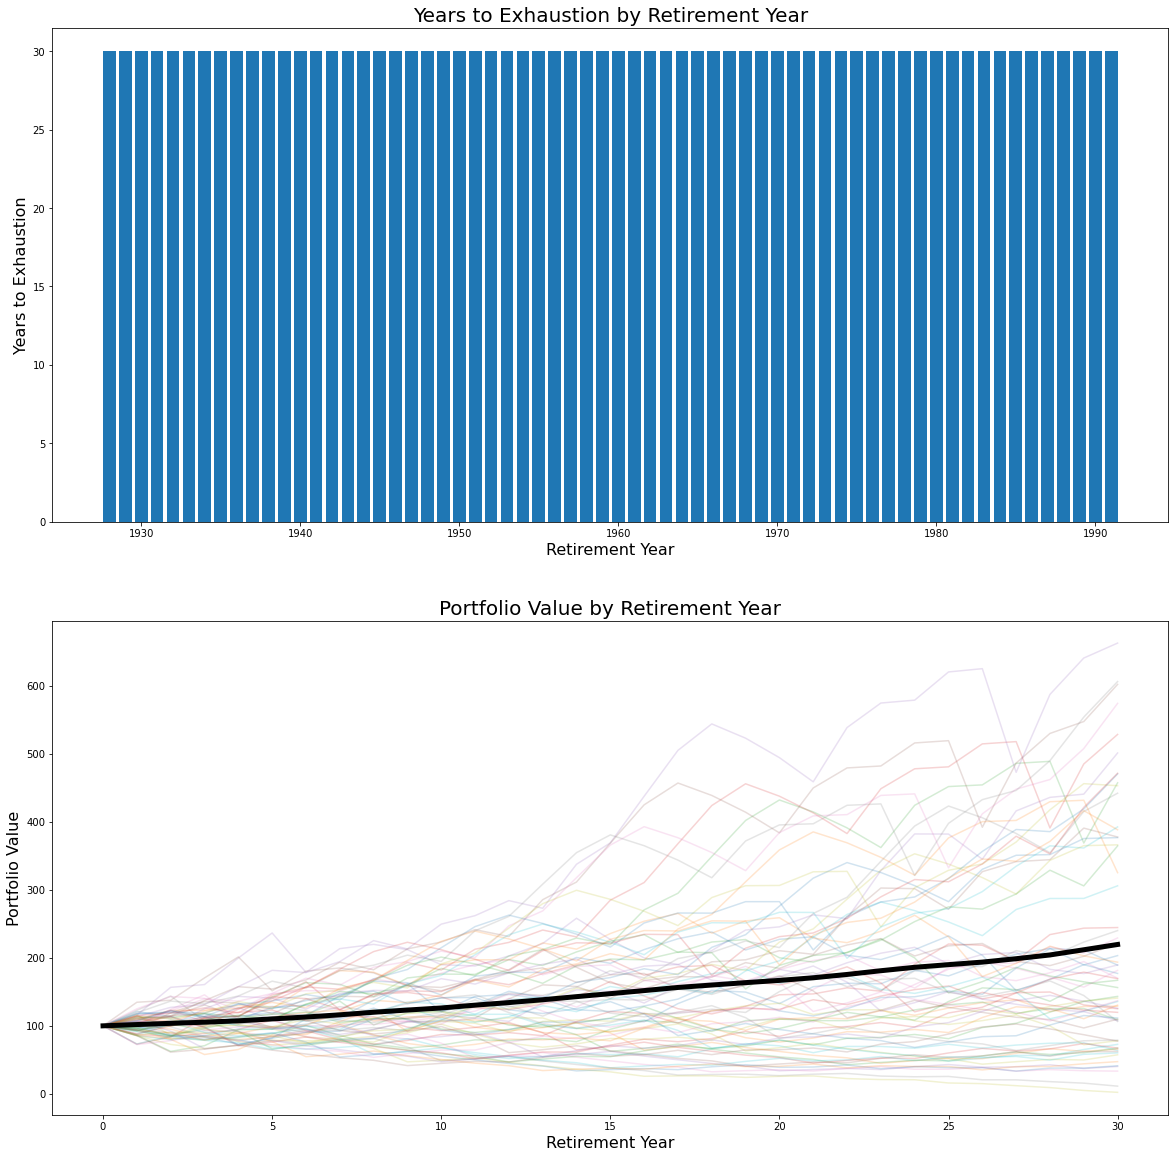

In [5]:
# Bengen 4% rule
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {}    # haven't defined any analysis options yet
})

print(s)

s.simulate() # returns array of trials (by default all historical retirement periods)
s.analyze()  # chart of latest simulation

In [6]:
# instead of historical, do 1000 montecarlo trials
# for each year of retirement, draw a random year from history to generate performance

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.montecarlo_trials at 0x7f1f09d04b30>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}
4.70% of portfolios exhausted by final year


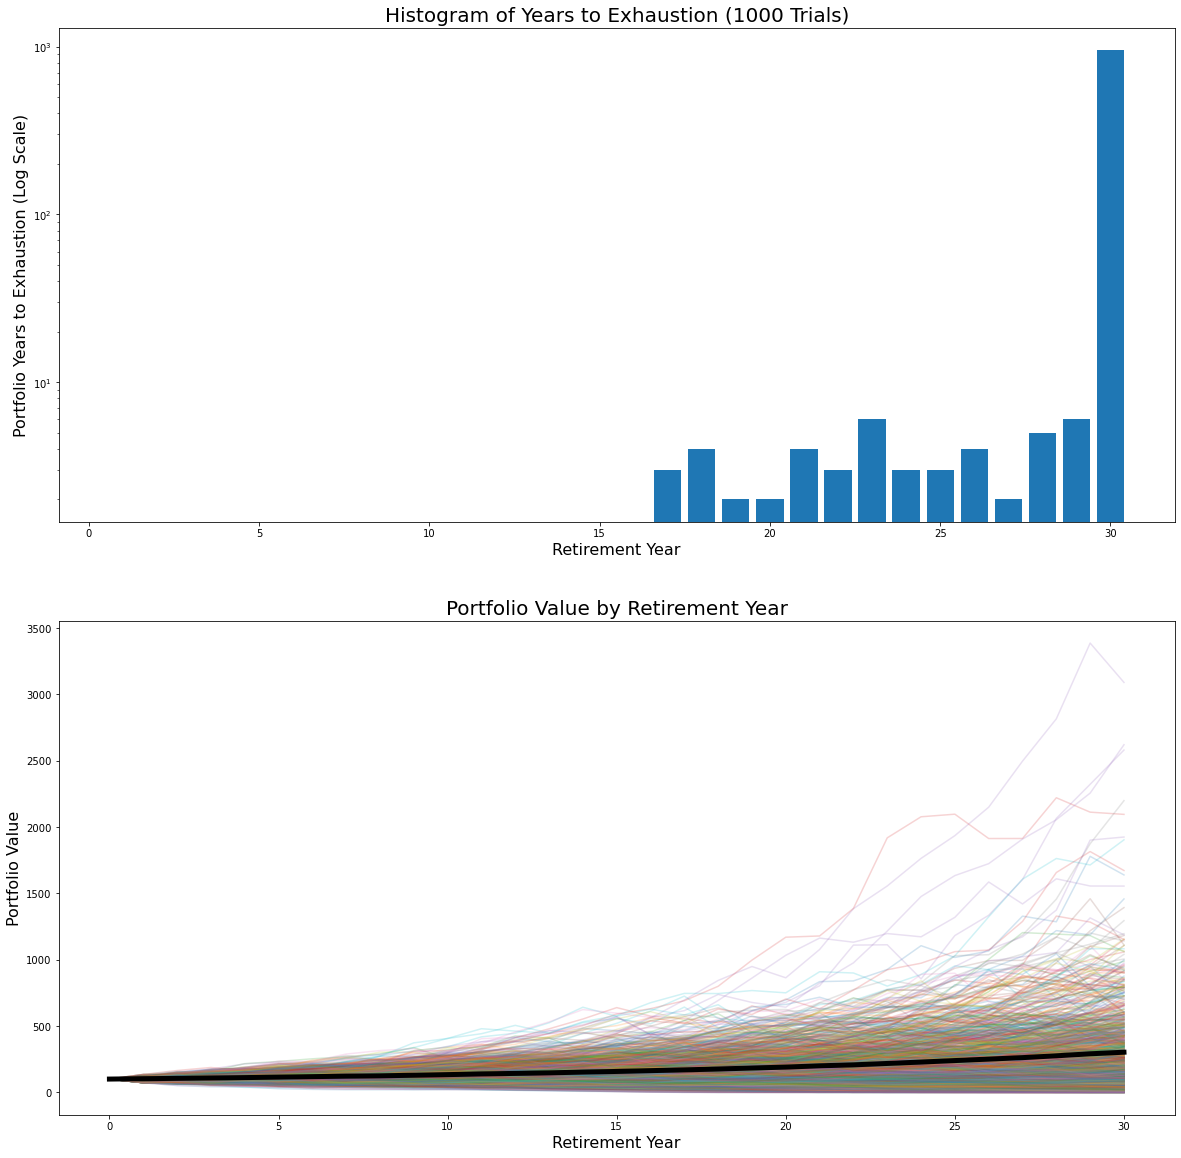

In [7]:
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30
NTRIALS = 1000

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

# don't keep 1000 historical arrays, just return a single eval for each trial
# eval is the years to exhaustion (30 if never exhausted)
s.simulate()
s.analyze()  # chart of latest simulation

In [8]:
# bengen rule
# suppose portfolio goes up, by induction if 4% is good for 30 years you can safely increase
# if portfolio goes down it's safer to do 4% of new value. if you spend 4% of value instead of fixed you could never go broke since you adjust on the way down
# so 4% seems like a pretty good number in the sense that in the long run you do OK

# I was curious does 4% hold up under monte carlo?

# so 4% historically has been an OK rule


In [9]:
# have github CI run tests automatically

# .analyze() ... run the 2 plots
# analyze_plotly, analyze
# use montecarlo to find a bad example with 4%
# use a fixture to test the eval code, clean up tests

# function to return ce value based on strategy
# ce value of a stream
# ce value of many ce streams
# run bayesian optimizaton, optuna etc.
# ce value of a set of streams over a mortality curve
# try convex optimization
# go through the scikit optimizers and see if there are other global optimizers that might work eg simulated annealing
# accept an arbitrary schedule, utility function, optimizer


# certainty_equivalent_mortality(k_list, mortality_table)
# calculate probability of being alive in years 1...k
# so now you have k lists with associated probabilities
#    certainty_adjust cash flow streams
#    not just full cash flow but range(nyears) cash flows 
#    then certainty adjust over the probability distribution of each sequence of cash flows
    

In [10]:
s.latest_simulation

[{'trial':       start_port  port_return  before_spend  spend    end_port  alloc_0  \
  1993  100.000000     0.099538    109.953821    4.0  105.953821      0.5   
  1946  105.953821    -0.105431     94.783045    4.0   90.783045      0.5   
  1970   90.783045    -0.011649     89.725518    4.0   85.725518      0.5   
  1934   85.725518     0.051552     90.144826    4.0   86.144826      0.5   
  1969   86.144826    -0.100469     77.489977    4.0   73.489977      0.5   
  1998   73.489977     0.163358     85.495187    4.0   81.495187      0.5   
  1963   81.495187     0.126418     91.797659    4.0   87.797659      0.5   
  1963   87.797659     0.126418     98.896879    4.0   94.896879      0.5   
  2020   94.896879     0.128584    107.099123    4.0  103.099123      0.5   
  1942  103.099123     0.011308    104.265015    4.0  100.265015      0.5   
  1948  100.265015    -0.028960     97.361353    4.0   93.361353      0.5   
  1973   93.361353    -0.105227     83.537221    4.0   79.537221   

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.montecarlo_trials at 0x7f1f0a06edd0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}
4.30% of portfolios exhausted by final year


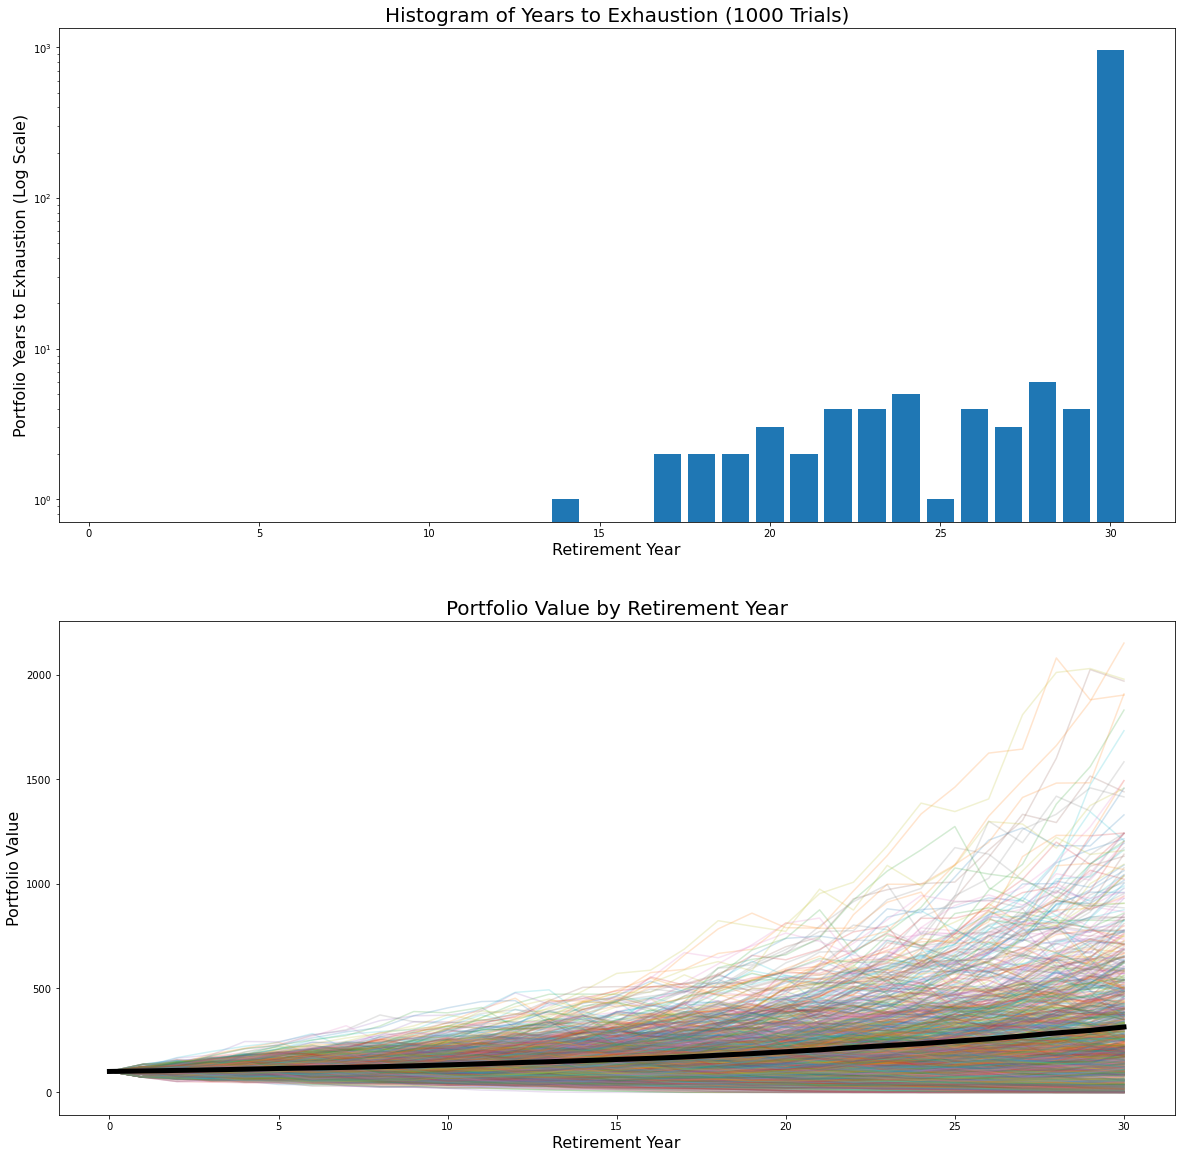

In [11]:
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30
NTRIALS = 1000

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()  # chart of latest simulation

In [25]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
ALLOC_BONDS = 0.4
N_RET_YEARS = 30

from functools import partial

def ce_experiment(gamma, fixed_spend, variable_spend, alloc_stocks, n_ret_years):

    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulation({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend},
        'evaluation': {},
        'analysis': {}    
    })
    s.simulate()
    return -SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze gamma=1 using partial
ce_experiment_1 = partial(ce_experiment, 1)
ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS, N_RET_YEARS)




-9519.256017841675

In [27]:
import optuna

def objective(gamma, trial):
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    n_ret_years = 30
    oobjective = partial(ce_experiment, gamma)

    return oobjective(fixed_spend, variable_spend, alloc_stocks, n_ret_years)

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]
for gamma in study_gammas:
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=10000)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    
    

[I 2021-02-05 16:53:52,393] A new study created in memory with name: no-name-32d173a2-6af2-4f5b-9a7d-533c68a48d35
[I 2021-02-05 16:53:52,521] Trial 0 finished with value: -9244.419396641788 and parameters: {'alloc_stocks': 0.09776004702198615, 'fixed_spend': 1.7598055313851169, 'variable_spend': 8.953058069209838}. Best is trial 0 with value: -9244.419396641788.
[I 2021-02-05 16:53:52,643] Trial 1 finished with value: -10586.970787635219 and parameters: {'alloc_stocks': 0.2875536153564474, 'fixed_spend': 2.1088311916567424, 'variable_spend': 4.34251816011257}. Best is trial 1 with value: -10586.970787635219.
[I 2021-02-05 16:53:52,765] Trial 2 finished with value: -10160.10314887717 and parameters: {'alloc_stocks': 0.333916099679329, 'fixed_spend': 3.0669679251090636, 'variable_spend': 7.263221142285805}. Best is trial 1 with value: -10586.970787635219.
[I 2021-02-05 16:53:52,887] Trial 3 finished with value: -10014.759611765985 and parameters: {'alloc_stocks': 0.33170550194081394, 'fi

[I 2021-02-05 16:53:56,588] Trial 31 finished with value: -14381.61277097408 and parameters: {'alloc_stocks': 0.9977273508799167, 'fixed_spend': 0.7824646717528426, 'variable_spend': 3.8058600352619503}. Best is trial 31 with value: -14381.61277097408.
[I 2021-02-05 16:53:56,718] Trial 32 finished with value: -14311.533905525212 and parameters: {'alloc_stocks': 0.9990766775377189, 'fixed_spend': 1.1182108549235306, 'variable_spend': 3.668193036958766}. Best is trial 31 with value: -14381.61277097408.
[I 2021-02-05 16:53:56,848] Trial 33 finished with value: -14614.152566318608 and parameters: {'alloc_stocks': 0.9971565068295415, 'fixed_spend': 1.2593819863289446, 'variable_spend': 3.9884954702208937}. Best is trial 33 with value: -14614.152566318608.
[I 2021-02-05 16:53:56,976] Trial 34 finished with value: -14371.488856362721 and parameters: {'alloc_stocks': 0.931712300124968, 'fixed_spend': 1.2781759505189685, 'variable_spend': 4.505881398047842}. Best is trial 33 with value: -14614.

[I 2021-02-05 16:54:00,591] Trial 62 finished with value: -15030.195433141416 and parameters: {'alloc_stocks': 0.9701114916314894, 'fixed_spend': 0.7352803060463585, 'variable_spend': 6.4751756268760445}. Best is trial 59 with value: -15075.224391221363.
[I 2021-02-05 16:54:00,719] Trial 63 finished with value: -14453.430822136761 and parameters: {'alloc_stocks': 0.895323423161289, 'fixed_spend': 0.35458147207117985, 'variable_spend': 6.481653059682247}. Best is trial 59 with value: -15075.224391221363.
[I 2021-02-05 16:54:00,847] Trial 64 finished with value: -15037.240401855415 and parameters: {'alloc_stocks': 0.9825585267372464, 'fixed_spend': 0.6533617608681637, 'variable_spend': 7.087513981910202}. Best is trial 59 with value: -15075.224391221363.
[I 2021-02-05 16:54:00,977] Trial 65 finished with value: -15063.65020535135 and parameters: {'alloc_stocks': 0.9887495304939964, 'fixed_spend': 0.6638202706051312, 'variable_spend': 7.175913531057824}. Best is trial 59 with value: -1507

[I 2021-02-05 16:54:04,591] Trial 93 finished with value: -14756.124930232018 and parameters: {'alloc_stocks': 0.9311565057859565, 'fixed_spend': 0.3008443497013764, 'variable_spend': 6.735490661798411}. Best is trial 68 with value: -15353.34849862602.
[I 2021-02-05 16:54:04,720] Trial 94 finished with value: -15048.821827689826 and parameters: {'alloc_stocks': 0.9981084716704031, 'fixed_spend': 0.4436010603365075, 'variable_spend': 7.730530785203808}. Best is trial 68 with value: -15353.34849862602.
[I 2021-02-05 16:54:04,849] Trial 95 finished with value: -14882.279124240813 and parameters: {'alloc_stocks': 0.9486910817956691, 'fixed_spend': 0.006463123017078687, 'variable_spend': 7.346437537965309}. Best is trial 68 with value: -15353.34849862602.
[I 2021-02-05 16:54:04,978] Trial 96 finished with value: -15095.645228256144 and parameters: {'alloc_stocks': 0.9683938124360055, 'fixed_spend': 0.18947996369007625, 'variable_spend': 6.932801977773163}. Best is trial 68 with value: -1535

[I 2021-02-05 16:54:08,592] Trial 124 finished with value: -15246.135576923261 and parameters: {'alloc_stocks': 0.9858522661155922, 'fixed_spend': 0.5935689175387039, 'variable_spend': 5.87494233895433}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:08,722] Trial 125 finished with value: -15333.76960375681 and parameters: {'alloc_stocks': 0.9999302048967583, 'fixed_spend': 0.7451107207535546, 'variable_spend': 5.623735585148211}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:08,851] Trial 126 finished with value: -15294.726625648473 and parameters: {'alloc_stocks': 0.9966668834401767, 'fixed_spend': 0.7464358045460399, 'variable_spend': 5.550358522009043}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:08,980] Trial 127 finished with value: -15306.976248449537 and parameters: {'alloc_stocks': 0.9994521145729245, 'fixed_spend': 0.8173032700056714, 'variable_spend': 5.536467383356121}. Best is trial 114 with value:

[I 2021-02-05 16:54:12,601] Trial 155 finished with value: -15216.690458090561 and parameters: {'alloc_stocks': 0.9992626078553377, 'fixed_spend': 0.7267367458545323, 'variable_spend': 5.063405039429285}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:12,730] Trial 156 finished with value: -15033.296966897815 and parameters: {'alloc_stocks': 0.9618960617565092, 'fixed_spend': 0.5482713946688734, 'variable_spend': 6.049707870919952}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:12,860] Trial 157 finished with value: -15187.80334816187 and parameters: {'alloc_stocks': 0.9805833188375789, 'fixed_spend': 0.4661111204129747, 'variable_spend': 5.550695620026134}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:12,989] Trial 158 finished with value: -14735.72822025868 and parameters: {'alloc_stocks': 0.9472227534396852, 'fixed_spend': 1.184777910597905, 'variable_spend': 6.3703517485681065}. Best is trial 114 with value:

[I 2021-02-05 16:54:16,614] Trial 186 finished with value: -15030.015365723812 and parameters: {'alloc_stocks': 0.968484998343155, 'fixed_spend': 0.3876593363729852, 'variable_spend': 6.954879348963463}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:16,744] Trial 187 finished with value: -15346.544491581044 and parameters: {'alloc_stocks': 0.999703365802969, 'fixed_spend': 0.5705258999927133, 'variable_spend': 6.488028846950553}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:16,873] Trial 188 finished with value: -15140.546113382734 and parameters: {'alloc_stocks': 0.9783087515415411, 'fixed_spend': 0.5519789488502098, 'variable_spend': 6.574516175419367}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:17,003] Trial 189 finished with value: -14936.037619117524 and parameters: {'alloc_stocks': 0.948104520840344, 'fixed_spend': 0.3054662719958805, 'variable_spend': 6.5143509746958195}. Best is trial 114 with value:

[I 2021-02-05 16:54:20,782] Trial 217 finished with value: -15389.953344273654 and parameters: {'alloc_stocks': 0.9996851111668678, 'fixed_spend': 0.056036207636456226, 'variable_spend': 7.150450160534511}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:20,912] Trial 218 finished with value: -15116.760100324973 and parameters: {'alloc_stocks': 0.9668035089027556, 'fixed_spend': 0.0048823636197613245, 'variable_spend': 7.048120180641202}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:21,042] Trial 219 finished with value: -15440.139919157555 and parameters: {'alloc_stocks': 0.9991340369042154, 'fixed_spend': 0.13959380260453053, 'variable_spend': 6.725809888711348}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:21,172] Trial 220 finished with value: -15375.318677119303 and parameters: {'alloc_stocks': 0.998279662493132, 'fixed_spend': 0.007736163101608823, 'variable_spend': 7.22778028305192}. Best is trial 114 wit

[I 2021-02-05 16:54:24,809] Trial 248 finished with value: -15072.040458303836 and parameters: {'alloc_stocks': 0.9640536891165803, 'fixed_spend': 0.2230810729513449, 'variable_spend': 6.77871828765718}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:24,939] Trial 249 finished with value: -15433.41864334523 and parameters: {'alloc_stocks': 0.9996163771472255, 'fixed_spend': 0.11376753768501732, 'variable_spend': 6.844481747598188}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:25,069] Trial 250 finished with value: -15381.546285001386 and parameters: {'alloc_stocks': 0.998700338394129, 'fixed_spend': 0.27832412042756194, 'variable_spend': 6.779721640455222}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:25,200] Trial 251 finished with value: -15390.991143469146 and parameters: {'alloc_stocks': 0.9994719494831149, 'fixed_spend': 0.2662746057085103, 'variable_spend': 6.790183907338208}. Best is trial 114 with value

[I 2021-02-05 16:54:28,849] Trial 279 finished with value: -15227.964455548117 and parameters: {'alloc_stocks': 0.979108047750948, 'fixed_spend': 0.1632204827055512, 'variable_spend': 6.801753480525718}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:28,981] Trial 280 finished with value: -15475.441986571605 and parameters: {'alloc_stocks': 0.9995710101656269, 'fixed_spend': 0.07865056511836092, 'variable_spend': 6.645288068784445}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:29,114] Trial 281 finished with value: -14936.403171314341 and parameters: {'alloc_stocks': 0.9427390384045485, 'fixed_spend': 0.07071768093940445, 'variable_spend': 6.603459360030215}. Best is trial 114 with value: -15498.102339762227.
[I 2021-02-05 16:54:29,248] Trial 282 finished with value: -15374.707438497753 and parameters: {'alloc_stocks': 0.9844840894728133, 'fixed_spend': 0.0014888682610835202, 'variable_spend': 6.325310969321514}. Best is trial 114 with 

[I 2021-02-05 16:54:32,921] Trial 310 finished with value: -15501.491005185817 and parameters: {'alloc_stocks': 0.9997534909013024, 'fixed_spend': 0.07100478970516502, 'variable_spend': 5.930674804162547}. Best is trial 305 with value: -15517.577019689234.
[I 2021-02-05 16:54:33,051] Trial 311 finished with value: -15205.51694298476 and parameters: {'alloc_stocks': 0.9684719290245711, 'fixed_spend': 0.017178824700139282, 'variable_spend': 6.000019930467442}. Best is trial 305 with value: -15517.577019689234.
[I 2021-02-05 16:54:33,182] Trial 312 finished with value: -15351.979207282457 and parameters: {'alloc_stocks': 0.9822350567922649, 'fixed_spend': 0.0034424279332233992, 'variable_spend': 6.13000160628857}. Best is trial 305 with value: -15517.577019689234.
[I 2021-02-05 16:54:33,312] Trial 313 finished with value: -15487.942411791737 and parameters: {'alloc_stocks': 0.9986038605303714, 'fixed_spend': 0.0807253704808001, 'variable_spend': 5.935156309059024}. Best is trial 305 with 

[I 2021-02-05 16:54:36,977] Trial 341 finished with value: -15078.474200428336 and parameters: {'alloc_stocks': 0.9571259788242683, 'fixed_spend': 0.09103288779801288, 'variable_spend': 5.98799601362766}. Best is trial 321 with value: -15518.26341662576.
[I 2021-02-05 16:54:37,109] Trial 342 finished with value: -3210.344872855494 and parameters: {'alloc_stocks': 0.9997401930590099, 'fixed_spend': 0.09068394984601193, 'variable_spend': 0.4400724354565977}. Best is trial 321 with value: -15518.26341662576.
[I 2021-02-05 16:54:37,239] Trial 343 finished with value: -15206.90398110024 and parameters: {'alloc_stocks': 0.9769792805455858, 'fixed_spend': 0.004159739274668242, 'variable_spend': 5.478001207157869}. Best is trial 321 with value: -15518.26341662576.
[I 2021-02-05 16:54:37,370] Trial 344 finished with value: -14864.91022249611 and parameters: {'alloc_stocks': 0.939810140130847, 'fixed_spend': 0.21792178848569627, 'variable_spend': 5.747224364959116}. Best is trial 321 with value:

[I 2021-02-05 16:54:41,037] Trial 372 finished with value: -15496.119824004363 and parameters: {'alloc_stocks': 0.9997935520650499, 'fixed_spend': 0.10652507681162993, 'variable_spend': 5.967171278398697}. Best is trial 345 with value: -15526.035880257768.
[I 2021-02-05 16:54:41,168] Trial 373 finished with value: -15107.85623302745 and parameters: {'alloc_stocks': 0.962767939359833, 'fixed_spend': 0.21753692676213357, 'variable_spend': 5.986412485059744}. Best is trial 345 with value: -15526.035880257768.
[I 2021-02-05 16:54:41,299] Trial 374 finished with value: -14470.471425455598 and parameters: {'alloc_stocks': 0.9059431756120918, 'fixed_spend': 0.15406320558665623, 'variable_spend': 5.372036418840093}. Best is trial 345 with value: -15526.035880257768.
[I 2021-02-05 16:54:41,430] Trial 375 finished with value: -15309.592609117572 and parameters: {'alloc_stocks': 0.9823739672153399, 'fixed_spend': 0.006626404343603926, 'variable_spend': 5.699439629342636}. Best is trial 345 with v

[I 2021-02-05 16:54:45,253] Trial 403 finished with value: -15506.318669200991 and parameters: {'alloc_stocks': 0.9993313229234263, 'fixed_spend': 0.00373030170698281, 'variable_spend': 5.8651039846978925}. Best is trial 345 with value: -15526.035880257768.
[I 2021-02-05 16:54:45,384] Trial 404 finished with value: -15173.764129311967 and parameters: {'alloc_stocks': 0.9789041542102155, 'fixed_spend': 0.00678079392536475, 'variable_spend': 5.303613310426292}. Best is trial 345 with value: -15526.035880257768.
[I 2021-02-05 16:54:45,515] Trial 405 finished with value: -15315.516445597841 and parameters: {'alloc_stocks': 0.9808972911260337, 'fixed_spend': 0.09344252997183497, 'variable_spend': 6.069948220476015}. Best is trial 345 with value: -15526.035880257768.
[I 2021-02-05 16:54:45,646] Trial 406 finished with value: -15449.160973848884 and parameters: {'alloc_stocks': 0.9987561508885741, 'fixed_spend': 0.08888817332619192, 'variable_spend': 5.636314391185016}. Best is trial 345 with

[I 2021-02-05 16:54:49,323] Trial 434 finished with value: -15316.115022035447 and parameters: {'alloc_stocks': 0.9795388031691561, 'fixed_spend': 0.00031733003553708, 'variable_spend': 5.960494461529007}. Best is trial 427 with value: -15528.309745582283.
[I 2021-02-05 16:54:49,457] Trial 435 finished with value: -15263.537570973494 and parameters: {'alloc_stocks': 0.9810814027463494, 'fixed_spend': 0.0011229136201422567, 'variable_spend': 5.536047061776973}. Best is trial 427 with value: -15528.309745582283.
[I 2021-02-05 16:54:49,588] Trial 436 finished with value: -15071.947366421737 and parameters: {'alloc_stocks': 0.9537549269064809, 'fixed_spend': 0.0008466277609080887, 'variable_spend': 6.13230182541675}. Best is trial 427 with value: -15528.309745582283.
[I 2021-02-05 16:54:49,720] Trial 437 finished with value: -15456.05876995387 and parameters: {'alloc_stocks': 0.9992046131148254, 'fixed_spend': 0.18930018840865048, 'variable_spend': 5.789839012360611}. Best is trial 427 wit

[I 2021-02-05 16:54:53,409] Trial 465 finished with value: -15331.994139019243 and parameters: {'alloc_stocks': 0.9809476346614446, 'fixed_spend': 0.004797539100258139, 'variable_spend': 6.465818036897773}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:54:53,540] Trial 466 finished with value: -13279.735081551698 and parameters: {'alloc_stocks': 0.9796359464177284, 'fixed_spend': 4.624062014276955, 'variable_spend': 6.109464412831304}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:54:53,672] Trial 467 finished with value: -14984.748204063799 and parameters: {'alloc_stocks': 0.9473148237248923, 'fixed_spend': 0.09285961317692994, 'variable_spend': 6.466413219097585}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:54:53,804] Trial 468 finished with value: -15196.338191244085 and parameters: {'alloc_stocks': 0.9664519794627875, 'fixed_spend': 0.0059564372078585014, 'variable_spend': 6.179749846689875}. Best is trial 460 with

[I 2021-02-05 16:54:57,501] Trial 496 finished with value: -14008.756973652271 and parameters: {'alloc_stocks': 0.8401871756764827, 'fixed_spend': 0.17424256725233547, 'variable_spend': 6.360030011919342}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:54:57,633] Trial 497 finished with value: -15178.747092930971 and parameters: {'alloc_stocks': 0.9667850716658868, 'fixed_spend': 0.09548215651791438, 'variable_spend': 6.261807440127375}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:54:57,765] Trial 498 finished with value: -15331.566705859586 and parameters: {'alloc_stocks': 0.9824464203168587, 'fixed_spend': 0.09725377523973935, 'variable_spend': 6.129560096709922}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:54:57,899] Trial 499 finished with value: -15456.839039490369 and parameters: {'alloc_stocks': 0.9997284485801787, 'fixed_spend': 0.20085662382452513, 'variable_spend': 6.4959408440763005}. Best is trial 460 with

[I 2021-02-05 16:55:01,599] Trial 527 finished with value: -15494.72288236062 and parameters: {'alloc_stocks': 0.9996444100771594, 'fixed_spend': 0.08622560360303783, 'variable_spend': 6.446810910038476}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:01,731] Trial 528 finished with value: -15302.873300576612 and parameters: {'alloc_stocks': 0.9818708219577483, 'fixed_spend': 0.09401857780501033, 'variable_spend': 6.605187274073792}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:01,868] Trial 529 finished with value: -15080.844641880121 and parameters: {'alloc_stocks': 0.9544338149302365, 'fixed_spend': 0.000716335995382173, 'variable_spend': 6.303381483402784}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:02,000] Trial 530 finished with value: -15052.538246389086 and parameters: {'alloc_stocks': 0.9999089518938978, 'fixed_spend': 1.3726411850804678, 'variable_spend': 6.705245988164208}. Best is trial 460 with v

[I 2021-02-05 16:55:05,712] Trial 558 finished with value: -15347.701793457 and parameters: {'alloc_stocks': 0.9826116452045673, 'fixed_spend': 0.0006877130343817374, 'variable_spend': 6.491299917560453}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:05,845] Trial 559 finished with value: -14785.338464022861 and parameters: {'alloc_stocks': 0.9236235359016688, 'fixed_spend': 9.05683839863905e-07, 'variable_spend': 6.198870102955723}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:05,978] Trial 560 finished with value: -12919.140578430743 and parameters: {'alloc_stocks': 0.705374361322026, 'fixed_spend': 0.2683303488621284, 'variable_spend': 6.5752402446856415}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:06,253] Trial 561 finished with value: -15481.650030433302 and parameters: {'alloc_stocks': 0.998513804738075, 'fixed_spend': 0.10293239889899941, 'variable_spend': 5.9321295943770815}. Best is trial 460 with v

[I 2021-02-05 16:55:09,979] Trial 589 finished with value: -15474.422056366257 and parameters: {'alloc_stocks': 0.9991045617025596, 'fixed_spend': 0.18388327450776218, 'variable_spend': 6.065324617265861}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:10,111] Trial 590 finished with value: -15207.637906891505 and parameters: {'alloc_stocks': 0.979736087551215, 'fixed_spend': 0.40940957829485036, 'variable_spend': 5.677275311049016}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:10,244] Trial 591 finished with value: -15072.333583471354 and parameters: {'alloc_stocks': 0.95360643420989, 'fixed_spend': 0.0005466462435327456, 'variable_spend': 6.191113664801335}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:10,377] Trial 592 finished with value: -15488.06524397798 and parameters: {'alloc_stocks': 0.9988210847415214, 'fixed_spend': 0.10370346581642437, 'variable_spend': 5.985162905953903}. Best is trial 460 with va

[I 2021-02-05 16:55:14,105] Trial 620 finished with value: -14786.212783157061 and parameters: {'alloc_stocks': 0.936393122220607, 'fixed_spend': 0.17341559143257623, 'variable_spend': 5.478154971424332}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:14,239] Trial 621 finished with value: -15504.791068597551 and parameters: {'alloc_stocks': 0.9991698534073409, 'fixed_spend': 0.002599787181846794, 'variable_spend': 5.863939433144578}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:14,372] Trial 622 finished with value: -15314.019968905268 and parameters: {'alloc_stocks': 0.9825146840821982, 'fixed_spend': 0.1653783934021157, 'variable_spend': 6.045142239674158}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:14,505] Trial 623 finished with value: -15439.600906350097 and parameters: {'alloc_stocks': 0.9999013242185084, 'fixed_spend': 0.3500043175682303, 'variable_spend': 6.150807561386829}. Best is trial 460 with va

[I 2021-02-05 16:55:18,238] Trial 651 finished with value: -15088.195922106297 and parameters: {'alloc_stocks': 0.9554330678998136, 'fixed_spend': 0.0005798097188742283, 'variable_spend': 6.12836055338841}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:18,372] Trial 652 finished with value: -15280.55563054997 and parameters: {'alloc_stocks': 0.9795730086656431, 'fixed_spend': 0.09634573234080757, 'variable_spend': 6.599903273530499}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:18,506] Trial 653 finished with value: -15124.34519450333 and parameters: {'alloc_stocks': 0.9646884494762304, 'fixed_spend': 0.20889036343289885, 'variable_spend': 5.927099048383393}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:18,639] Trial 654 finished with value: -13465.893922521245 and parameters: {'alloc_stocks': 0.9801558984723172, 'fixed_spend': 4.30995072558567, 'variable_spend': 6.198555550548536}. Best is trial 460 with valu

[I 2021-02-05 16:55:22,379] Trial 682 finished with value: -15315.080963346518 and parameters: {'alloc_stocks': 0.9787540378743694, 'fixed_spend': 0.002040745679259423, 'variable_spend': 6.397984239487624}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:22,512] Trial 683 finished with value: -15298.735435901126 and parameters: {'alloc_stocks': 0.9832293169427763, 'fixed_spend': 0.26416410944753826, 'variable_spend': 6.170508672512394}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:22,646] Trial 684 finished with value: -15030.305865261871 and parameters: {'alloc_stocks': 0.9539770061636172, 'fixed_spend': 0.16645707296705967, 'variable_spend': 6.456263929624861}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:22,780] Trial 685 finished with value: -15289.570737774411 and parameters: {'alloc_stocks': 0.9819671408375726, 'fixed_spend': 0.001032187667507426, 'variable_spend': 6.9028886269763134}. Best is trial 460 wi

[I 2021-02-05 16:55:26,530] Trial 713 finished with value: -15184.809652448603 and parameters: {'alloc_stocks': 0.9675571736622275, 'fixed_spend': 0.09859626581565009, 'variable_spend': 6.118357022899002}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:26,664] Trial 714 finished with value: -14916.365394359345 and parameters: {'alloc_stocks': 0.9480477997660993, 'fixed_spend': 0.3146779733656637, 'variable_spend': 6.658573116865307}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:26,797] Trial 715 finished with value: -15485.710691959539 and parameters: {'alloc_stocks': 0.9986115630470062, 'fixed_spend': 0.003999291462657928, 'variable_spend': 5.763256043904487}. Best is trial 460 with value: -15529.117752357815.
[I 2021-02-05 16:55:26,930] Trial 716 finished with value: -15338.351332861712 and parameters: {'alloc_stocks': 0.980932297369206, 'fixed_spend': 0.0019304467300236144, 'variable_spend': 6.356862337567733}. Best is trial 460 with

[I 2021-02-05 16:55:30,687] Trial 744 finished with value: -15049.80030363764 and parameters: {'alloc_stocks': 0.9826309889741107, 'fixed_spend': 1.2487538341106441, 'variable_spend': 6.183439610904789}. Best is trial 728 with value: -15529.157148070371.
[I 2021-02-05 16:55:30,963] Trial 745 finished with value: -15461.40193482548 and parameters: {'alloc_stocks': 0.9993921551613958, 'fixed_spend': 0.17368663567324522, 'variable_spend': 6.499000950770191}. Best is trial 728 with value: -15529.157148070371.
[I 2021-02-05 16:55:31,097] Trial 746 finished with value: -15089.613317505828 and parameters: {'alloc_stocks': 0.9575530126242084, 'fixed_spend': 0.09610382223478624, 'variable_spend': 6.241693086541229}. Best is trial 728 with value: -15529.157148070371.
[I 2021-02-05 16:55:31,232] Trial 747 finished with value: -14725.673657616862 and parameters: {'alloc_stocks': 0.9226726053142102, 'fixed_spend': 0.09857554773308856, 'variable_spend': 6.769295092109616}. Best is trial 728 with val

[I 2021-02-05 16:55:35,010] Trial 775 finished with value: -14119.045837288104 and parameters: {'alloc_stocks': 0.9988198544629913, 'fixed_spend': 3.4506898581434102, 'variable_spend': 6.127618869462676}. Best is trial 728 with value: -15529.157148070371.
[I 2021-02-05 16:55:35,146] Trial 776 finished with value: -15328.785501028015 and parameters: {'alloc_stocks': 0.9811859623899633, 'fixed_spend': 0.003551410671396524, 'variable_spend': 6.5418387328842105}. Best is trial 728 with value: -15529.157148070371.
[I 2021-02-05 16:55:35,280] Trial 777 finished with value: -15019.748710026215 and parameters: {'alloc_stocks': 0.9503141244802576, 'fixed_spend': 0.09566087600190556, 'variable_spend': 6.2894929077121615}. Best is trial 728 with value: -15529.157148070371.
[I 2021-02-05 16:55:35,414] Trial 778 finished with value: -15478.367426434415 and parameters: {'alloc_stocks': 0.9995227932636763, 'fixed_spend': 0.17983619513567195, 'variable_spend': 6.021445209892205}. Best is trial 728 wit

[I 2021-02-05 16:55:39,184] Trial 806 finished with value: -15527.489430977148 and parameters: {'alloc_stocks': 0.9997552662926266, 'fixed_spend': 0.0011852427129854927, 'variable_spend': 6.323321420997946}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:39,319] Trial 807 finished with value: -15316.208528071256 and parameters: {'alloc_stocks': 0.9821933824382916, 'fixed_spend': 0.003931938160694795, 'variable_spend': 6.739835930460322}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:39,455] Trial 808 finished with value: -14230.160749702518 and parameters: {'alloc_stocks': 0.9176410771717156, 'fixed_spend': 1.9732394352641665, 'variable_spend': 6.484817431007048}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:39,590] Trial 809 finished with value: -15154.53318442771 and parameters: {'alloc_stocks': 0.9643888544518676, 'fixed_spend': 0.09163349268809416, 'variable_spend': 6.338124420822742}. Best is trial 804 with

[I 2021-02-05 16:55:43,372] Trial 837 finished with value: -15218.02708295876 and parameters: {'alloc_stocks': 0.9690637666126938, 'fixed_spend': 0.00421020656284737, 'variable_spend': 6.428858279374496}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:43,507] Trial 838 finished with value: -15318.092748707859 and parameters: {'alloc_stocks': 0.9816067087134985, 'fixed_spend': 0.090697015272363, 'variable_spend': 5.9734681319633705}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:43,641] Trial 839 finished with value: -15434.228546620143 and parameters: {'alloc_stocks': 0.9987260015542057, 'fixed_spend': 0.2148102326069451, 'variable_spend': 5.697616658122593}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:43,778] Trial 840 finished with value: -14601.939918632725 and parameters: {'alloc_stocks': 0.9065473940776984, 'fixed_spend': 0.08854406714358379, 'variable_spend': 6.55530626719547}. Best is trial 804 with valu

[I 2021-02-05 16:55:47,567] Trial 868 finished with value: -12838.098835713226 and parameters: {'alloc_stocks': 0.6958696446888829, 'fixed_spend': 0.4728927349255467, 'variable_spend': 6.1165445693860026}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:47,702] Trial 869 finished with value: -15270.104688883966 and parameters: {'alloc_stocks': 0.9808460184828309, 'fixed_spend': 0.23759679680054988, 'variable_spend': 5.853185255493597}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:47,837] Trial 870 finished with value: -15504.551841901193 and parameters: {'alloc_stocks': 0.99998750162151, 'fixed_spend': 0.09355617403586701, 'variable_spend': 6.306258896587306}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:47,972] Trial 871 finished with value: -15180.038010385906 and parameters: {'alloc_stocks': 0.9659519195851153, 'fixed_spend': 0.0019293173231426759, 'variable_spend': 6.552075316375028}. Best is trial 804 with 

[I 2021-02-05 16:55:51,765] Trial 899 finished with value: -13865.898325883609 and parameters: {'alloc_stocks': 0.9806901446410078, 'fixed_spend': 3.9241812067351756, 'variable_spend': 5.845909501861349}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:51,900] Trial 900 finished with value: -15170.249003135377 and parameters: {'alloc_stocks': 0.964222591328921, 'fixed_spend': 0.0052521296826006335, 'variable_spend': 6.437097526583374}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:52,035] Trial 901 finished with value: -15500.134428226957 and parameters: {'alloc_stocks': 0.9994391897750734, 'fixed_spend': 0.09557675259866491, 'variable_spend': 6.0754538106210525}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:52,170] Trial 902 finished with value: -15349.622395927418 and parameters: {'alloc_stocks': 0.982071808567314, 'fixed_spend': 0.0009627079525311397, 'variable_spend': 6.363420739082445}. Best is trial 804 wit

[I 2021-02-05 16:55:56,121] Trial 930 finished with value: -15499.42652792386 and parameters: {'alloc_stocks': 0.9991659042360566, 'fixed_spend': 0.09045801839823892, 'variable_spend': 6.2327148500272935}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:56,257] Trial 931 finished with value: -15319.594890752069 and parameters: {'alloc_stocks': 0.980612460768562, 'fixed_spend': 0.0036946893393180916, 'variable_spend': 5.892123820478374}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:56,394] Trial 932 finished with value: -15441.151984297376 and parameters: {'alloc_stocks': 0.9992740819147662, 'fixed_spend': 0.22710670263763869, 'variable_spend': 6.526030006326668}. Best is trial 804 with value: -15529.417590034027.
[I 2021-02-05 16:55:56,531] Trial 933 finished with value: -15503.036410472705 and parameters: {'alloc_stocks': 0.9996311228551445, 'fixed_spend': 0.0863538966390195, 'variable_spend': 6.305602689803326}. Best is trial 804 with 

[I 2021-02-05 16:56:00,347] Trial 961 finished with value: -14969.886844614757 and parameters: {'alloc_stocks': 0.9430023889948679, 'fixed_spend': 0.005315425888318981, 'variable_spend': 6.270131208201968}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:00,483] Trial 962 finished with value: -15186.933856102296 and parameters: {'alloc_stocks': 0.9654109484755017, 'fixed_spend': 0.0018626707645500646, 'variable_spend': 6.174048402757284}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:00,619] Trial 963 finished with value: -15324.30270908786 and parameters: {'alloc_stocks': 0.980543087581176, 'fixed_spend': 0.003690014439816263, 'variable_spend': 5.9472347850971685}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:00,755] Trial 964 finished with value: -15521.895991863257 and parameters: {'alloc_stocks': 0.9995473540275429, 'fixed_spend': 0.0015094551443072793, 'variable_spend': 6.3974559349714415}. Best is trial 948

[I 2021-02-05 16:56:04,572] Trial 992 finished with value: -15514.99181430314 and parameters: {'alloc_stocks': 0.9998479587344711, 'fixed_spend': 0.00397648288109469, 'variable_spend': 5.897868584678453}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:04,708] Trial 993 finished with value: -15529.567368494027 and parameters: {'alloc_stocks': 0.9998258031640775, 'fixed_spend': 0.0005619223918344831, 'variable_spend': 6.126168082517483}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:04,844] Trial 994 finished with value: -15446.790270807833 and parameters: {'alloc_stocks': 0.9994306284445877, 'fixed_spend': 0.08526531823136968, 'variable_spend': 5.585074910793999}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:04,981] Trial 995 finished with value: -15258.770577021933 and parameters: {'alloc_stocks': 0.9790966454152997, 'fixed_spend': 0.17386685770918597, 'variable_spend': 5.7894538558632425}. Best is trial 948 wit

[I 2021-02-05 16:56:08,804] Trial 1023 finished with value: -15525.670989404734 and parameters: {'alloc_stocks': 0.9993680186148963, 'fixed_spend': 0.0013268875505050997, 'variable_spend': 6.206088133224602}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:08,940] Trial 1024 finished with value: -15274.990771472658 and parameters: {'alloc_stocks': 0.9819402632717029, 'fixed_spend': 0.23477368840458904, 'variable_spend': 5.789102314109663}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:09,077] Trial 1025 finished with value: -14978.653787079384 and parameters: {'alloc_stocks': 0.9461432176289241, 'fixed_spend': 0.09028545421183441, 'variable_spend': 6.095152411116977}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:09,213] Trial 1026 finished with value: -15484.361432805708 and parameters: {'alloc_stocks': 0.9999485121529218, 'fixed_spend': 0.16953617294058287, 'variable_spend': 6.274480273674396}. Best is trial 948

[I 2021-02-05 16:56:13,048] Trial 1054 finished with value: -15468.518904305965 and parameters: {'alloc_stocks': 0.9989221908630382, 'fixed_spend': 0.18122698627744374, 'variable_spend': 5.947134626179168}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:13,185] Trial 1055 finished with value: -15484.593065782792 and parameters: {'alloc_stocks': 0.9992301756142377, 'fixed_spend': 0.0017727251330298603, 'variable_spend': 6.734131042058355}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:13,322] Trial 1056 finished with value: -15091.022702977534 and parameters: {'alloc_stocks': 0.9632721801347593, 'fixed_spend': 0.09807653336470111, 'variable_spend': 5.63205521643469}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:13,459] Trial 1057 finished with value: -15440.982415150083 and parameters: {'alloc_stocks': 0.9997580989292156, 'fixed_spend': 0.3395377229200005, 'variable_spend': 6.148860071618259}. Best is trial 948 w

[I 2021-02-05 16:56:17,302] Trial 1085 finished with value: -15520.83377833973 and parameters: {'alloc_stocks': 0.9999531295730335, 'fixed_spend': 0.007306025214174703, 'variable_spend': 6.450795262477912}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:17,441] Trial 1086 finished with value: -15458.022066302055 and parameters: {'alloc_stocks': 0.999255669723642, 'fixed_spend': 0.2470968098995392, 'variable_spend': 6.231765818430131}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:17,578] Trial 1087 finished with value: -12970.8998118186 and parameters: {'alloc_stocks': 0.9669223929297726, 'fixed_spend': 0.004715480603788178, 'variable_spend': 3.1566193698979643}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:17,715] Trial 1088 finished with value: -14610.447863524641 and parameters: {'alloc_stocks': 0.937862392818114, 'fixed_spend': 0.00241692045555556, 'variable_spend': 7.960916198659087}. Best is trial 948 with

[I 2021-02-05 16:56:21,707] Trial 1116 finished with value: -15267.944381969646 and parameters: {'alloc_stocks': 0.9818397141271159, 'fixed_spend': 0.0005133810404889373, 'variable_spend': 5.522102048066298}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:21,846] Trial 1117 finished with value: -15034.825639267328 and parameters: {'alloc_stocks': 0.9521929112894928, 'fixed_spend': 0.0934240122263542, 'variable_spend': 6.394898906480227}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:21,984] Trial 1118 finished with value: -9161.220937699582 and parameters: {'alloc_stocks': 0.09254318880799928, 'fixed_spend': 0.17379960356282775, 'variable_spend': 6.075755748500767}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:22,122] Trial 1119 finished with value: -15503.629824107811 and parameters: {'alloc_stocks': 0.9998686072000077, 'fixed_spend': 0.0030553529530827246, 'variable_spend': 6.634467015016913}. Best is trial 94

[I 2021-02-05 16:56:25,984] Trial 1147 finished with value: -15163.864121690567 and parameters: {'alloc_stocks': 0.9676924626002317, 'fixed_spend': 0.16967032105583818, 'variable_spend': 6.396591313570831}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:26,121] Trial 1148 finished with value: -15475.816824324247 and parameters: {'alloc_stocks': 0.9986868961470061, 'fixed_spend': 0.09490589125915833, 'variable_spend': 5.831014823815188}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:26,259] Trial 1149 finished with value: -15465.62087586768 and parameters: {'alloc_stocks': 0.9998597320664641, 'fixed_spend': 0.2254537005752441, 'variable_spend': 6.319569750480143}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:26,397] Trial 1150 finished with value: -14884.217946380413 and parameters: {'alloc_stocks': 0.9363526811366176, 'fixed_spend': 0.09336795913233348, 'variable_spend': 6.086832623424262}. Best is trial 948 wit

[I 2021-02-05 16:56:30,262] Trial 1178 finished with value: -15037.325342065924 and parameters: {'alloc_stocks': 0.9539200297707466, 'fixed_spend': 0.0012677812562433017, 'variable_spend': 6.802603749053339}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:30,400] Trial 1179 finished with value: -15297.635543721917 and parameters: {'alloc_stocks': 0.9823569592750663, 'fixed_spend': 0.23243111536438216, 'variable_spend': 6.197510286014801}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:30,537] Trial 1180 finished with value: -15461.053806633554 and parameters: {'alloc_stocks': 0.9988657786370293, 'fixed_spend': 0.002281294950318844, 'variable_spend': 5.607650848288188}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:30,677] Trial 1181 finished with value: -15168.688370759883 and parameters: {'alloc_stocks': 0.9647097149530274, 'fixed_spend': 0.003687570991374157, 'variable_spend': 6.538146648061172}. Best is trial 9

[I 2021-02-05 16:56:34,545] Trial 1209 finished with value: -15341.06717782246 and parameters: {'alloc_stocks': 0.9810533100490914, 'fixed_spend': 0.004367124910084277, 'variable_spend': 6.272534453162823}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:34,686] Trial 1210 finished with value: -15456.91245129019 and parameters: {'alloc_stocks': 0.9994777978630686, 'fixed_spend': 0.23060616655179847, 'variable_spend': 5.863760630517655}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:34,824] Trial 1211 finished with value: -15171.730708268115 and parameters: {'alloc_stocks': 0.9641382574201647, 'fixed_spend': 0.0034681454417726026, 'variable_spend': 6.102792747806264}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:34,961] Trial 1212 finished with value: -14849.293616738887 and parameters: {'alloc_stocks': 0.9351862875578916, 'fixed_spend': 0.1698093494027023, 'variable_spend': 6.517019271146139}. Best is trial 948 w

[I 2021-02-05 16:56:38,840] Trial 1240 finished with value: -15176.623909027767 and parameters: {'alloc_stocks': 0.9679676075457692, 'fixed_spend': 0.09955145348348485, 'variable_spend': 5.912834213166176}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:38,978] Trial 1241 finished with value: -14007.422054092222 and parameters: {'alloc_stocks': 0.9810190987585498, 'fixed_spend': 3.3033382276085397, 'variable_spend': 6.292370194225317}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:39,116] Trial 1242 finished with value: -15452.474708184 and parameters: {'alloc_stocks': 0.9988636953577298, 'fixed_spend': 0.24700889648726754, 'variable_spend': 5.946024803399314}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:39,255] Trial 1243 finished with value: -15057.724900389549 and parameters: {'alloc_stocks': 0.9582249467932114, 'fixed_spend': 0.08936915946689777, 'variable_spend': 6.7676077071266905}. Best is trial 948 with

[I 2021-02-05 16:56:43,142] Trial 1271 finished with value: -14984.448100600348 and parameters: {'alloc_stocks': 0.947009787676524, 'fixed_spend': 0.002098753028265366, 'variable_spend': 5.8684898627047835}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:43,281] Trial 1272 finished with value: -15487.491251552601 and parameters: {'alloc_stocks': 0.9998940856327264, 'fixed_spend': 0.16570923559089373, 'variable_spend': 6.172355126135618}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:43,420] Trial 1273 finished with value: -15454.949751557015 and parameters: {'alloc_stocks': 0.9990868273999972, 'fixed_spend': 0.0018018171093899058, 'variable_spend': 5.568311658574428}. Best is trial 948 with value: -15530.860890639287.
[I 2021-02-05 16:56:43,559] Trial 1274 finished with value: -15330.99022256869 and parameters: {'alloc_stocks': 0.9815726694983982, 'fixed_spend': 0.0003178825253847637, 'variable_spend': 6.569481659130843}. Best is trial 9

[I 2021-02-05 16:56:47,598] Trial 1302 finished with value: -15148.58967513046 and parameters: {'alloc_stocks': 0.9686209469930248, 'fixed_spend': 0.24199470403689954, 'variable_spend': 6.466890493611372}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:47,737] Trial 1303 finished with value: -15515.771496077978 and parameters: {'alloc_stocks': 0.9999564330394666, 'fixed_spend': 0.0005357311562466157, 'variable_spend': 5.886905603892039}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:47,877] Trial 1304 finished with value: -15276.61841178855 and parameters: {'alloc_stocks': 0.9812565325962505, 'fixed_spend': 0.002268089326533153, 'variable_spend': 5.586012438158735}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:48,018] Trial 1305 finished with value: -15053.780676793176 and parameters: {'alloc_stocks': 0.9537602383904886, 'fixed_spend': 0.09031407947168973, 'variable_spend': 6.157298864969626}. Best is trial 1289

[I 2021-02-05 16:56:51,925] Trial 1333 finished with value: -15150.74229639944 and parameters: {'alloc_stocks': 0.9668684081000554, 'fixed_spend': 0.09543254507481894, 'variable_spend': 5.775635892498663}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:52,064] Trial 1334 finished with value: -15352.671677565395 and parameters: {'alloc_stocks': 0.9822768254584779, 'fixed_spend': 0.006358773075409966, 'variable_spend': 6.273981945696688}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:52,203] Trial 1335 finished with value: -14834.856039310926 and parameters: {'alloc_stocks': 0.9384802597105847, 'fixed_spend': 0.237484717559008, 'variable_spend': 6.763115844044737}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:52,343] Trial 1336 finished with value: -15181.534441005715 and parameters: {'alloc_stocks': 0.9661211930682461, 'fixed_spend': 0.0027976380033292647, 'variable_spend': 5.955265058954463}. Best is trial 1289 

[I 2021-02-05 16:56:56,253] Trial 1364 finished with value: -15529.637763188239 and parameters: {'alloc_stocks': 0.9997306662011256, 'fixed_spend': 0.0001751755909293459, 'variable_spend': 6.211447821799595}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:56,392] Trial 1365 finished with value: -15442.732177503276 and parameters: {'alloc_stocks': 0.9991926099300296, 'fixed_spend': 0.09981522436837027, 'variable_spend': 6.7940256196281235}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:56,532] Trial 1366 finished with value: -14921.439635558236 and parameters: {'alloc_stocks': 0.942504998541849, 'fixed_spend': 0.1705336871764263, 'variable_spend': 6.458801128841816}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:56:56,671] Trial 1367 finished with value: -15219.493968924271 and parameters: {'alloc_stocks': 0.9994183110275233, 'fixed_spend': 0.32158358514393415, 'variable_spend': 7.400881757821342}. Best is trial 1289

[I 2021-02-05 16:57:00,595] Trial 1395 finished with value: -14449.858818346656 and parameters: {'alloc_stocks': 0.8917980561928467, 'fixed_spend': 0.0013811212209906185, 'variable_spend': 6.931450538486707}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:00,734] Trial 1396 finished with value: -15352.526192657915 and parameters: {'alloc_stocks': 0.9823800444265192, 'fixed_spend': 0.004396761948346786, 'variable_spend': 6.109123698002208}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:00,874] Trial 1397 finished with value: -15469.187690023118 and parameters: {'alloc_stocks': 0.9996830064204232, 'fixed_spend': 0.16429777417221622, 'variable_spend': 6.477758477020028}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:01,014] Trial 1398 finished with value: -15018.248859166233 and parameters: {'alloc_stocks': 0.9545872887465463, 'fixed_spend': 0.28599839205167604, 'variable_spend': 6.2499255804703555}. Best is trial 1

[I 2021-02-05 16:57:04,950] Trial 1426 finished with value: -15491.970738433374 and parameters: {'alloc_stocks': 0.9991854435118525, 'fixed_spend': 0.09457907700946938, 'variable_spend': 5.954325293335662}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:05,090] Trial 1427 finished with value: -15158.950706375344 and parameters: {'alloc_stocks': 0.9666553465121395, 'fixed_spend': 0.17754361821301531, 'variable_spend': 6.167994698292307}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:05,232] Trial 1428 finished with value: -15498.778591691607 and parameters: {'alloc_stocks': 0.9992195970311929, 'fixed_spend': 0.002430456156367772, 'variable_spend': 6.622651737866756}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:05,371] Trial 1429 finished with value: -15521.101096076236 and parameters: {'alloc_stocks': 0.9991003211845902, 'fixed_spend': 0.00017555552060766807, 'variable_spend': 6.32565854256896}. Best is trial 12

[I 2021-02-05 16:57:09,312] Trial 1457 finished with value: -12775.479570940024 and parameters: {'alloc_stocks': 0.6922182939706911, 'fixed_spend': 0.09317776758848624, 'variable_spend': 5.951761355868047}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:09,455] Trial 1458 finished with value: -14908.199586102 and parameters: {'alloc_stocks': 0.9667519349710515, 'fixed_spend': 0.17275980895634419, 'variable_spend': 4.978516932829303}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:09,595] Trial 1459 finished with value: -15320.365065463156 and parameters: {'alloc_stocks': 0.9809631472276825, 'fixed_spend': 0.08435897098657573, 'variable_spend': 6.2366040175289115}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:09,736] Trial 1460 finished with value: -15348.558458145671 and parameters: {'alloc_stocks': 0.9823483196951368, 'fixed_spend': 0.006583659649899955, 'variable_spend': 6.412154133765558}. Best is trial 1289 w

[I 2021-02-05 16:57:13,831] Trial 1488 finished with value: -15146.14437061793 and parameters: {'alloc_stocks': 0.9677032825660129, 'fixed_spend': 0.17008050309467657, 'variable_spend': 5.779370597278518}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:13,973] Trial 1489 finished with value: -14929.290186667713 and parameters: {'alloc_stocks': 0.939161411321553, 'fixed_spend': 0.00031536052182739444, 'variable_spend': 6.472670188230126}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:14,114] Trial 1490 finished with value: -15301.100945201215 and parameters: {'alloc_stocks': 0.9838572958113143, 'fixed_spend': 0.27620747785153454, 'variable_spend': 6.204702207932352}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:14,255] Trial 1491 finished with value: -15315.17532103233 and parameters: {'alloc_stocks': 0.981586773845182, 'fixed_spend': 0.09552152499398474, 'variable_spend': 5.950241970921584}. Best is trial 1289 w

[I 2021-02-05 16:57:18,212] Trial 1519 finished with value: -15267.577155816325 and parameters: {'alloc_stocks': 0.9805835676782076, 'fixed_spend': 0.2781906157757725, 'variable_spend': 5.986917192449304}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:18,353] Trial 1520 finished with value: -15082.19596398265 and parameters: {'alloc_stocks': 0.9546056816679154, 'fixed_spend': 0.0008461571338821654, 'variable_spend': 6.322919418560856}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:18,494] Trial 1521 finished with value: -15334.346536422345 and parameters: {'alloc_stocks': 0.9804199966513475, 'fixed_spend': 0.0032162764320400965, 'variable_spend': 6.1450713325466335}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:18,638] Trial 1522 finished with value: -15140.23193998175 and parameters: {'alloc_stocks': 0.9649564108092963, 'fixed_spend': 0.10099697603611364, 'variable_spend': 5.849161336832821}. Best is trial 128

[I 2021-02-05 16:57:22,592] Trial 1550 finished with value: -11366.544326919102 and parameters: {'alloc_stocks': 0.4915407671540212, 'fixed_spend': 0.0015796505061628663, 'variable_spend': 6.166813387315016}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:22,733] Trial 1551 finished with value: -15357.305575071805 and parameters: {'alloc_stocks': 0.9836538758816391, 'fixed_spend': 0.0015668989055133689, 'variable_spend': 5.962506606572313}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:22,877] Trial 1552 finished with value: -11943.890994182038 and parameters: {'alloc_stocks': 0.5741972427554627, 'fixed_spend': 0.0003999417418698598, 'variable_spend': 6.289419833615846}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:23,019] Trial 1553 finished with value: -15507.600868496065 and parameters: {'alloc_stocks': 0.9997776123696835, 'fixed_spend': 0.002475970842675069, 'variable_spend': 6.593437955557901}. Best is tria

[I 2021-02-05 16:57:26,987] Trial 1581 finished with value: -15517.398080716648 and parameters: {'alloc_stocks': 0.9998348486479025, 'fixed_spend': 0.0009795111008899556, 'variable_spend': 5.917088813604914}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:27,129] Trial 1582 finished with value: -15465.002943875752 and parameters: {'alloc_stocks': 0.9997780409372456, 'fixed_spend': 0.2479013225979424, 'variable_spend': 6.153490384822392}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:27,271] Trial 1583 finished with value: -15477.769768038834 and parameters: {'alloc_stocks': 0.9995407897506013, 'fixed_spend': 0.1477877624066348, 'variable_spend': 6.419613862890638}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:27,412] Trial 1584 finished with value: -15138.470178660355 and parameters: {'alloc_stocks': 0.9657065070611763, 'fixed_spend': 0.08938372365025278, 'variable_spend': 5.7624574210936395}. Best is trial 1289

[I 2021-02-05 16:57:31,392] Trial 1612 finished with value: -14925.589427202485 and parameters: {'alloc_stocks': 0.943545783581631, 'fixed_spend': 0.17208618856551589, 'variable_spend': 6.526486950419756}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:31,535] Trial 1613 finished with value: -15417.42157796054 and parameters: {'alloc_stocks': 0.9998381536822458, 'fixed_spend': 0.402355352912188, 'variable_spend': 6.297156771612465}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:31,676] Trial 1614 finished with value: -15310.71196206416 and parameters: {'alloc_stocks': 0.9817810507128302, 'fixed_spend': 0.09026229173974996, 'variable_spend': 5.866598036183805}. Best is trial 1289 with value: -15531.15039564449.
[I 2021-02-05 16:57:31,818] Trial 1615 finished with value: -15152.318303587053 and parameters: {'alloc_stocks': 0.9620328159284054, 'fixed_spend': 0.005098943851302712, 'variable_spend': 6.145425289859479}. Best is trial 1289 with

[I 2021-02-05 16:57:35,803] Trial 1643 finished with value: -15087.664986065283 and parameters: {'alloc_stocks': 0.9552740813698385, 'fixed_spend': 0.0004000375260605582, 'variable_spend': 6.369146735634102}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:35,945] Trial 1644 finished with value: -15315.149518118742 and parameters: {'alloc_stocks': 0.9811882622494726, 'fixed_spend': 0.09042319707284198, 'variable_spend': 5.991058766847608}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:36,087] Trial 1645 finished with value: -15286.409867806797 and parameters: {'alloc_stocks': 0.9815699966576075, 'fixed_spend': 0.2488268851349329, 'variable_spend': 6.169491873193884}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:36,230] Trial 1646 finished with value: -15120.867164102237 and parameters: {'alloc_stocks': 0.9643688121821453, 'fixed_spend': 0.16970257167815825, 'variable_spend': 5.840765206019529}. Best is trial 1

[I 2021-02-05 16:57:40,378] Trial 1674 finished with value: -15460.643939713591 and parameters: {'alloc_stocks': 0.9999381088032089, 'fixed_spend': 0.1613462077220263, 'variable_spend': 5.721575688142281}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:40,522] Trial 1675 finished with value: -15499.789439211054 and parameters: {'alloc_stocks': 0.999902446769866, 'fixed_spend': 0.09067765461648321, 'variable_spend': 5.949376986007308}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:40,665] Trial 1676 finished with value: -15298.79037506973 and parameters: {'alloc_stocks': 0.9999602713206015, 'fixed_spend': 0.5759070132123404, 'variable_spend': 6.762721149956578}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:40,808] Trial 1677 finished with value: -15313.504955132412 and parameters: {'alloc_stocks': 0.9819523423268366, 'fixed_spend': 0.10135690575369229, 'variable_spend': 6.483997326961231}. Best is trial 1627 w

[I 2021-02-05 16:57:44,810] Trial 1705 finished with value: -15215.544921060973 and parameters: {'alloc_stocks': 0.9818717336622806, 'fixed_spend': 0.00397954343021875, 'variable_spend': 5.337754013046312}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:44,953] Trial 1706 finished with value: -14931.201636614442 and parameters: {'alloc_stocks': 0.9418048005363178, 'fixed_spend': 0.002144518923361572, 'variable_spend': 5.848842313930907}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:45,096] Trial 1707 finished with value: -15178.781762277267 and parameters: {'alloc_stocks': 0.9689253514598271, 'fixed_spend': 0.1648279096142291, 'variable_spend': 6.364190100728862}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:45,239] Trial 1708 finished with value: -15343.42707408021 and parameters: {'alloc_stocks': 0.9815191562811179, 'fixed_spend': 0.002291879532840244, 'variable_spend': 6.084034264520083}. Best is trial 16

[I 2021-02-05 16:57:49,249] Trial 1736 finished with value: -15175.830195631752 and parameters: {'alloc_stocks': 0.968513408688499, 'fixed_spend': 0.0017055848394432107, 'variable_spend': 6.804152010295125}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:49,393] Trial 1737 finished with value: -15280.235975792948 and parameters: {'alloc_stocks': 0.9794889945937302, 'fixed_spend': 0.18742010220232821, 'variable_spend': 6.231721607416475}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:49,536] Trial 1738 finished with value: -15338.476481351245 and parameters: {'alloc_stocks': 0.9823847660784464, 'fixed_spend': 0.003980256758773775, 'variable_spend': 5.90283359006866}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:49,680] Trial 1739 finished with value: -14834.413291829733 and parameters: {'alloc_stocks': 0.9386859585915971, 'fixed_spend': 0.3956540720034793, 'variable_spend': 6.447763418895861}. Best is trial 16

[I 2021-02-05 16:57:53,703] Trial 1767 finished with value: -15499.82224902018 and parameters: {'alloc_stocks': 0.999459434805114, 'fixed_spend': 0.09959263773278025, 'variable_spend': 6.236015654725267}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:53,846] Trial 1768 finished with value: -15442.212559446161 and parameters: {'alloc_stocks': 0.9991612052708709, 'fixed_spend': 0.252613656791314, 'variable_spend': 5.790742585305598}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:53,990] Trial 1769 finished with value: -9302.145401341095 and parameters: {'alloc_stocks': 0.11323488549128424, 'fixed_spend': 0.09882455916300838, 'variable_spend': 6.449569109363089}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:54,134] Trial 1770 finished with value: -15429.162867524974 and parameters: {'alloc_stocks': 0.9997826619044556, 'fixed_spend': 0.3876507109066757, 'variable_spend': 5.966696322948449}. Best is trial 1627 wi

[I 2021-02-05 16:57:58,164] Trial 1798 finished with value: -15035.691844088215 and parameters: {'alloc_stocks': 0.9506998219860735, 'fixed_spend': 0.004204847102980255, 'variable_spend': 6.51419890695715}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:58,309] Trial 1799 finished with value: -15312.836928320467 and parameters: {'alloc_stocks': 0.9821528829895572, 'fixed_spend': 0.16266250653956, 'variable_spend': 6.116245535843534}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:58,453] Trial 1800 finished with value: -9657.68566485287 and parameters: {'alloc_stocks': 0.20933977176655538, 'fixed_spend': 0.10314218873076585, 'variable_spend': 5.823380260627109}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:57:58,597] Trial 1801 finished with value: -15081.746651666508 and parameters: {'alloc_stocks': 0.9628791232866211, 'fixed_spend': 0.3236606530636922, 'variable_spend': 6.362076601061405}. Best is trial 1627 wi

[I 2021-02-05 16:58:02,637] Trial 1829 finished with value: -14812.463585787827 and parameters: {'alloc_stocks': 0.9286139486244999, 'fixed_spend': 0.10575858898502835, 'variable_spend': 6.21593003694562}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:02,781] Trial 1830 finished with value: -15192.279117463331 and parameters: {'alloc_stocks': 0.968637181695496, 'fixed_spend': 0.005145424900355227, 'variable_spend': 6.679851722766957}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:02,925] Trial 1831 finished with value: -15306.366085992013 and parameters: {'alloc_stocks': 0.983098214547008, 'fixed_spend': 0.22632019394598268, 'variable_spend': 6.07198751187313}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:03,069] Trial 1832 finished with value: -15415.480887637714 and parameters: {'alloc_stocks': 0.9992584061025647, 'fixed_spend': 0.00041489702569639126, 'variable_spend': 7.109686896752068}. Best is trial 16

[I 2021-02-05 16:58:07,264] Trial 1860 finished with value: -15285.410145852693 and parameters: {'alloc_stocks': 0.9811527532956335, 'fixed_spend': 0.0017595889547265117, 'variable_spend': 6.879918677395803}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:07,409] Trial 1861 finished with value: -15109.825422804315 and parameters: {'alloc_stocks': 0.966061137806787, 'fixed_spend': 0.2381231584118763, 'variable_spend': 6.614156590242298}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:07,554] Trial 1862 finished with value: -12588.185553480944 and parameters: {'alloc_stocks': 0.707123638026055, 'fixed_spend': 0.16615781845360456, 'variable_spend': 8.665051844467085}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:07,699] Trial 1863 finished with value: -15528.926756350556 and parameters: {'alloc_stocks': 0.9999524343925129, 'fixed_spend': 0.0008027329107432209, 'variable_spend': 6.340564581280848}. Best is trial 1

[I 2021-02-05 16:58:11,753] Trial 1891 finished with value: -15531.174197365654 and parameters: {'alloc_stocks': 0.9999230757409745, 'fixed_spend': 4.2257858839514126e-05, 'variable_spend': 6.258883139017692}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:11,898] Trial 1892 finished with value: -15083.3359627338 and parameters: {'alloc_stocks': 0.9644038312057414, 'fixed_spend': 0.10067237725654955, 'variable_spend': 6.946679111440544}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:12,043] Trial 1893 finished with value: -15288.573540924044 and parameters: {'alloc_stocks': 0.9815328534048294, 'fixed_spend': 0.1665920151425175, 'variable_spend': 6.511416845735628}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:12,188] Trial 1894 finished with value: -15474.243740496004 and parameters: {'alloc_stocks': 0.9999352979207268, 'fixed_spend': 0.1016518887791483, 'variable_spend': 6.626030396515491}. Best is trial 162

[I 2021-02-05 16:58:16,247] Trial 1922 finished with value: -14916.19813117497 and parameters: {'alloc_stocks': 0.9461045165047146, 'fixed_spend': 0.3182109888112362, 'variable_spend': 5.804155245751236}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:16,392] Trial 1923 finished with value: -15524.732626444802 and parameters: {'alloc_stocks': 0.9995252514449339, 'fixed_spend': 0.001567151357901746, 'variable_spend': 6.0781076874369}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:16,538] Trial 1924 finished with value: -15466.326701630169 and parameters: {'alloc_stocks': 0.9998182590304499, 'fixed_spend': 0.22114298395236306, 'variable_spend': 6.321207506342675}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:16,683] Trial 1925 finished with value: -15122.205102014304 and parameters: {'alloc_stocks': 0.9639420996294898, 'fixed_spend': 0.15631547668971252, 'variable_spend': 6.519176156730752}. Best is trial 1627 

[I 2021-02-05 16:58:20,752] Trial 1953 finished with value: -15460.258809115985 and parameters: {'alloc_stocks': 0.999488649000559, 'fixed_spend': 0.001360200327992809, 'variable_spend': 5.573214519618172}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:20,897] Trial 1954 finished with value: -15026.23907267156 and parameters: {'alloc_stocks': 0.9526741849592836, 'fixed_spend': 0.0036603568555804177, 'variable_spend': 5.773354447923506}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:21,043] Trial 1955 finished with value: -15157.288193702589 and parameters: {'alloc_stocks': 0.9681496988542099, 'fixed_spend': 0.17751713383255216, 'variable_spend': 5.85023649146059}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:21,188] Trial 1956 finished with value: -15477.646850336296 and parameters: {'alloc_stocks': 0.9992397321641838, 'fixed_spend': 0.16698595069077835, 'variable_spend': 5.996254873432479}. Best is trial 16

[I 2021-02-05 16:58:25,272] Trial 1984 finished with value: -13827.638318669051 and parameters: {'alloc_stocks': 0.8166348027977728, 'fixed_spend': 0.0030623485505143753, 'variable_spend': 6.448301965711813}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:25,417] Trial 1985 finished with value: -15505.172873757365 and parameters: {'alloc_stocks': 0.9998827126373098, 'fixed_spend': 0.08633383440154464, 'variable_spend': 6.028343995631318}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:25,563] Trial 1986 finished with value: -15527.215763139138 and parameters: {'alloc_stocks': 0.9996057321932478, 'fixed_spend': 0.0044141337669697045, 'variable_spend': 6.1879868398893345}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:25,709] Trial 1987 finished with value: -15521.812930018314 and parameters: {'alloc_stocks': 0.9996553702142722, 'fixed_spend': 0.004164195919752414, 'variable_spend': 6.404328524057551}. Best is tr

[I 2021-02-05 16:58:29,793] Trial 2015 finished with value: -9599.298278582519 and parameters: {'alloc_stocks': 0.23326178541006404, 'fixed_spend': 0.24351071061517515, 'variable_spend': 5.08699435739895}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:29,939] Trial 2016 finished with value: -14993.70670376713 and parameters: {'alloc_stocks': 0.9559155208707909, 'fixed_spend': 0.412599635433255, 'variable_spend': 6.3818654236367856}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:30,085] Trial 2017 finished with value: -15501.138598898833 and parameters: {'alloc_stocks': 0.9999735769204657, 'fixed_spend': 0.10281418190767803, 'variable_spend': 6.008708839952521}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:30,231] Trial 2018 finished with value: -15343.345236782952 and parameters: {'alloc_stocks': 0.9811507005787706, 'fixed_spend': 0.00036889283163185746, 'variable_spend': 6.223705243410649}. Best is trial 16

[I 2021-02-05 16:58:34,477] Trial 2046 finished with value: -15077.807704273964 and parameters: {'alloc_stocks': 0.954625470381661, 'fixed_spend': 0.00483597547685148, 'variable_spend': 6.092190653595267}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:34,628] Trial 2047 finished with value: -15295.656997192582 and parameters: {'alloc_stocks': 0.982474227198469, 'fixed_spend': 0.16852183719377642, 'variable_spend': 5.810081557025374}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:34,774] Trial 2048 finished with value: -15494.147869091175 and parameters: {'alloc_stocks': 0.9994342128158645, 'fixed_spend': 0.09085496899620081, 'variable_spend': 6.408342631747099}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:34,927] Trial 2049 finished with value: -15359.27828206206 and parameters: {'alloc_stocks': 0.9995114920636348, 'fixed_spend': 0.33392008718351845, 'variable_spend': 6.839861109924658}. Best is trial 1627 

[I 2021-02-05 16:58:39,032] Trial 2077 finished with value: -14975.188284787582 and parameters: {'alloc_stocks': 0.9515008753816991, 'fixed_spend': 0.3325103595325158, 'variable_spend': 5.931400828223859}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:39,179] Trial 2078 finished with value: -15303.589285500602 and parameters: {'alloc_stocks': 0.9830541536747255, 'fixed_spend': 0.22358164172770587, 'variable_spend': 6.291781275368204}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:39,325] Trial 2079 finished with value: -13427.621107747655 and parameters: {'alloc_stocks': 0.7926347925179429, 'fixed_spend': 0.11196911058037821, 'variable_spend': 5.280467815039192}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:39,472] Trial 2080 finished with value: -10263.422313836527 and parameters: {'alloc_stocks': 0.309106139511799, 'fixed_spend': 0.09234895659787964, 'variable_spend': 6.096029482549248}. Best is trial 1627

[I 2021-02-05 16:58:43,586] Trial 2108 finished with value: -15024.642393917438 and parameters: {'alloc_stocks': 0.948734840804039, 'fixed_spend': 0.006194633628748888, 'variable_spend': 6.2366154071022475}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:43,733] Trial 2109 finished with value: -15518.228818908101 and parameters: {'alloc_stocks': 0.9997837015403381, 'fixed_spend': 0.005985922710712284, 'variable_spend': 5.945744277515388}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:43,880] Trial 2110 finished with value: -15503.361071730778 and parameters: {'alloc_stocks': 0.9988134958023569, 'fixed_spend': 0.002780542333493294, 'variable_spend': 6.540038735421115}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:44,027] Trial 2111 finished with value: -15452.266764854357 and parameters: {'alloc_stocks': 0.9989476888767657, 'fixed_spend': 0.24224011030605497, 'variable_spend': 6.314560977557175}. Best is trial

[I 2021-02-05 16:58:48,148] Trial 2139 finished with value: -15494.319906979908 and parameters: {'alloc_stocks': 0.9991117466131767, 'fixed_spend': 0.10217615810743697, 'variable_spend': 6.04848964940161}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:48,296] Trial 2140 finished with value: -14106.354202890834 and parameters: {'alloc_stocks': 0.8534686504140185, 'fixed_spend': 0.2258287035376639, 'variable_spend': 6.591112991048882}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:48,444] Trial 2141 finished with value: -14365.215303360474 and parameters: {'alloc_stocks': 0.8796185860439538, 'fixed_spend': 0.09418349759057854, 'variable_spend': 6.2610607308380315}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:48,591] Trial 2142 finished with value: -14853.011951947865 and parameters: {'alloc_stocks': 0.9354294322294774, 'fixed_spend': 0.16916992325040184, 'variable_spend': 5.9468983020897355}. Best is trial 16

[I 2021-02-05 16:58:52,717] Trial 2170 finished with value: -15306.887363814458 and parameters: {'alloc_stocks': 0.9799258446718491, 'fixed_spend': 0.09088968658985964, 'variable_spend': 6.080813205640019}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:52,865] Trial 2171 finished with value: -8815.2007201999 and parameters: {'alloc_stocks': 0.005131055844417087, 'fixed_spend': 0.2456390898216996, 'variable_spend': 6.191396954617615}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:53,012] Trial 2172 finished with value: -14984.914798834325 and parameters: {'alloc_stocks': 0.9497578421063099, 'fixed_spend': 0.0006531585796938303, 'variable_spend': 5.69673550780615}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:53,160] Trial 2173 finished with value: -15322.592766260386 and parameters: {'alloc_stocks': 0.9804318025732156, 'fixed_spend': 0.0017521056170598276, 'variable_spend': 5.936118863271373}. Best is trial 1

[I 2021-02-05 16:58:57,301] Trial 2201 finished with value: -2514.660466064215 and parameters: {'alloc_stocks': 0.9989749371507934, 'fixed_spend': 0.08693229509215636, 'variable_spend': 0.3334484562723574}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:57,449] Trial 2202 finished with value: -15191.634891661633 and parameters: {'alloc_stocks': 0.9679375550060358, 'fixed_spend': 0.0048155722779089595, 'variable_spend': 6.625041767293748}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:57,597] Trial 2203 finished with value: -14902.65909790065 and parameters: {'alloc_stocks': 0.9381569864123366, 'fixed_spend': 0.09473887734516717, 'variable_spend': 6.368525510443696}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:58:57,746] Trial 2204 finished with value: -15327.368382456607 and parameters: {'alloc_stocks': 0.9796379281302396, 'fixed_spend': 0.0009233549440815288, 'variable_spend': 6.155900244892912}. Best is trial

[I 2021-02-05 16:59:02,046] Trial 2232 finished with value: -15446.83086100993 and parameters: {'alloc_stocks': 0.9995836317968845, 'fixed_spend': 0.1546882173030819, 'variable_spend': 6.6781814221069355}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:02,195] Trial 2233 finished with value: -15298.170697659098 and parameters: {'alloc_stocks': 0.9818774832210511, 'fixed_spend': 0.20974357928132253, 'variable_spend': 6.066628697820171}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:02,342] Trial 2234 finished with value: -14446.095335333666 and parameters: {'alloc_stocks': 0.915410343602549, 'fixed_spend': 0.0006192091252952387, 'variable_spend': 5.051800637731736}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:02,491] Trial 2235 finished with value: -13247.819319806222 and parameters: {'alloc_stocks': 0.7530266815639719, 'fixed_spend': 1.043379950060506, 'variable_spend': 6.394143175989485}. Best is trial 1627

[I 2021-02-05 16:59:06,650] Trial 2263 finished with value: -15305.50813420452 and parameters: {'alloc_stocks': 0.9802535284975241, 'fixed_spend': 0.0015272567054253436, 'variable_spend': 5.803462845885242}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:06,798] Trial 2264 finished with value: -15467.969365461722 and parameters: {'alloc_stocks': 0.9996338117266277, 'fixed_spend': 0.22734683702274502, 'variable_spend': 6.203414582399814}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:06,947] Trial 2265 finished with value: -15483.544503125468 and parameters: {'alloc_stocks': 0.9998250183369358, 'fixed_spend': 0.1713116528688657, 'variable_spend': 6.023459049502706}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:07,096] Trial 2266 finished with value: -15032.206634746817 and parameters: {'alloc_stocks': 0.9502706909171875, 'fixed_spend': 0.0041695075735533535, 'variable_spend': 6.505008642025275}. Best is trial 

[I 2021-02-05 16:59:11,264] Trial 2294 finished with value: -15318.280847067654 and parameters: {'alloc_stocks': 0.9808713909332796, 'fixed_spend': 0.0035037449610212977, 'variable_spend': 5.857252893826663}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:11,413] Trial 2295 finished with value: -15510.683525505046 and parameters: {'alloc_stocks': 0.9991740875827153, 'fixed_spend': 0.006490985988371123, 'variable_spend': 6.48489695577611}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:11,562] Trial 2296 finished with value: -14996.961981121658 and parameters: {'alloc_stocks': 0.9535032141029299, 'fixed_spend': 0.32731838344562636, 'variable_spend': 6.294997753361061}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:11,711] Trial 2297 finished with value: -15315.142805028736 and parameters: {'alloc_stocks': 0.9807558397693164, 'fixed_spend': 0.09334490157784674, 'variable_spend': 6.1009779388004555}. Best is trial

[I 2021-02-05 16:59:15,884] Trial 2325 finished with value: -14806.938989117261 and parameters: {'alloc_stocks': 0.9258302382513365, 'fixed_spend': 0.0019399297559866806, 'variable_spend': 6.352379574505939}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:16,032] Trial 2326 finished with value: -15139.508811169635 and parameters: {'alloc_stocks': 0.9666758126738423, 'fixed_spend': 0.24167378225298622, 'variable_spend': 5.9653904536077835}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:16,180] Trial 2327 finished with value: -15274.060312224774 and parameters: {'alloc_stocks': 0.982886957862544, 'fixed_spend': 0.1487445126430849, 'variable_spend': 6.767191087435708}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:16,327] Trial 2328 finished with value: -15522.723060078388 and parameters: {'alloc_stocks': 0.9990481211240029, 'fixed_spend': 0.0002605179485907965, 'variable_spend': 6.204896988478358}. Best is trial

[I 2021-02-05 16:59:20,471] Trial 2356 finished with value: -14906.220439532626 and parameters: {'alloc_stocks': 0.9366764048341236, 'fixed_spend': 0.0005162368541006678, 'variable_spend': 6.462312328512733}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:20,619] Trial 2357 finished with value: -13857.95388640945 and parameters: {'alloc_stocks': 0.8287331379338694, 'fixed_spend': 0.16176148408519023, 'variable_spend': 5.730964446423927}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:20,767] Trial 2358 finished with value: -15435.84171104907 and parameters: {'alloc_stocks': 0.9994927349514343, 'fixed_spend': 0.35343704366135814, 'variable_spend': 6.0435565460055685}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:20,915] Trial 2359 finished with value: -15451.739212019493 and parameters: {'alloc_stocks': 0.9994325830010031, 'fixed_spend': 0.09322294833889241, 'variable_spend': 6.766625301585789}. Best is trial 1

[I 2021-02-05 16:59:25,070] Trial 2387 finished with value: -15334.666480580709 and parameters: {'alloc_stocks': 0.9808487674936651, 'fixed_spend': 0.00031435568343278226, 'variable_spend': 6.035586709809349}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:25,219] Trial 2388 finished with value: -14978.745281278025 and parameters: {'alloc_stocks': 0.9518421945380205, 'fixed_spend': 0.24333634083289735, 'variable_spend': 5.768912352272421}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:25,367] Trial 2389 finished with value: -15158.86857904563 and parameters: {'alloc_stocks': 0.9676049375565945, 'fixed_spend': 0.16370793166230976, 'variable_spend': 6.475971593690579}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:25,515] Trial 2390 finished with value: -15217.170376590766 and parameters: {'alloc_stocks': 0.9784313183316264, 'fixed_spend': 0.09229445733178564, 'variable_spend': 6.952429625714768}. Best is trial 

[I 2021-02-05 16:59:29,846] Trial 2418 finished with value: -15345.858126230742 and parameters: {'alloc_stocks': 0.9815861924483094, 'fixed_spend': 0.00428017263933222, 'variable_spend': 6.30131309481949}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:29,997] Trial 2419 finished with value: -15501.98688471326 and parameters: {'alloc_stocks': 0.9995893207690402, 'fixed_spend': 0.0004970617595125076, 'variable_spend': 5.802378368852625}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:30,148] Trial 2420 finished with value: -14945.232096695418 and parameters: {'alloc_stocks': 0.9538492517368116, 'fixed_spend': 0.0016044277767543317, 'variable_spend': 5.373114093707103}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:30,298] Trial 2421 finished with value: -15258.223286145403 and parameters: {'alloc_stocks': 0.9820750924646979, 'fixed_spend': 0.28886752976489577, 'variable_spend': 6.519402025176436}. Best is trial 

[I 2021-02-05 16:59:34,508] Trial 2449 finished with value: -15256.059395391894 and parameters: {'alloc_stocks': 0.9786012615466255, 'fixed_spend': 0.0016644562277980275, 'variable_spend': 5.614928651140169}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:34,657] Trial 2450 finished with value: -15514.734014133646 and parameters: {'alloc_stocks': 0.9993733646243336, 'fixed_spend': 0.0024536897334429906, 'variable_spend': 5.944080147227131}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:34,806] Trial 2451 finished with value: -11540.040411401314 and parameters: {'alloc_stocks': 0.5123317236122217, 'fixed_spend': 0.16214458440300247, 'variable_spend': 6.2268146156784905}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:34,956] Trial 2452 finished with value: -14980.86931543743 and parameters: {'alloc_stocks': 0.9511697915164559, 'fixed_spend': 0.24289961834636029, 'variable_spend': 5.843985135470943}. Best is tria

[I 2021-02-05 16:59:39,135] Trial 2480 finished with value: -15324.969809128906 and parameters: {'alloc_stocks': 0.9828768026965158, 'fixed_spend': 0.08888869073329628, 'variable_spend': 5.897361775289673}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:39,287] Trial 2481 finished with value: -15447.467097545705 and parameters: {'alloc_stocks': 0.9999673660266093, 'fixed_spend': 0.2599596495591756, 'variable_spend': 6.4375125190324205}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:39,437] Trial 2482 finished with value: -15051.855208387933 and parameters: {'alloc_stocks': 0.9515333520111584, 'fixed_spend': 0.0013567050094089087, 'variable_spend': 6.1828561415644465}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:39,586] Trial 2483 finished with value: -15151.843577904765 and parameters: {'alloc_stocks': 0.9662451510340767, 'fixed_spend': 0.0981217160786284, 'variable_spend': 6.601392056012386}. Best is trial 

[I 2021-02-05 16:59:43,790] Trial 2511 finished with value: -15122.343662040348 and parameters: {'alloc_stocks': 0.9631119450781206, 'fixed_spend': 0.1885980787151198, 'variable_spend': 6.176172871234333}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:43,940] Trial 2512 finished with value: -12862.376421900517 and parameters: {'alloc_stocks': 0.6992649971810168, 'fixed_spend': 0.08605497800613265, 'variable_spend': 6.99289215676079}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:44,089] Trial 2513 finished with value: -15272.072601141972 and parameters: {'alloc_stocks': 0.982128683295401, 'fixed_spend': 0.3255802044617129, 'variable_spend': 5.985701290384549}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:44,239] Trial 2514 finished with value: -15518.93115337647 and parameters: {'alloc_stocks': 0.9993212613594931, 'fixed_spend': 0.0063737504555948935, 'variable_spend': 6.384563893102603}. Best is trial 1627 

[I 2021-02-05 16:59:48,442] Trial 2542 finished with value: -15265.874745036017 and parameters: {'alloc_stocks': 0.9803895801243585, 'fixed_spend': 0.24391587995801023, 'variable_spend': 6.400119964409642}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:48,592] Trial 2543 finished with value: -15324.046227977706 and parameters: {'alloc_stocks': 0.9816380470104277, 'fixed_spend': 0.09589354639087556, 'variable_spend': 6.137962112303361}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:48,744] Trial 2544 finished with value: -15470.570128285435 and parameters: {'alloc_stocks': 0.9993182913752443, 'fixed_spend': 0.1661110982403653, 'variable_spend': 5.87321518356694}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:48,894] Trial 2545 finished with value: -15461.347735240251 and parameters: {'alloc_stocks': 0.999598782504446, 'fixed_spend': 0.003635849176464628, 'variable_spend': 6.895506159328724}. Best is trial 1627

[I 2021-02-05 16:59:53,110] Trial 2573 finished with value: -15130.913352502339 and parameters: {'alloc_stocks': 0.9656240449990772, 'fixed_spend': 0.09056257638539443, 'variable_spend': 6.741781289800579}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:53,260] Trial 2574 finished with value: -15525.357272518559 and parameters: {'alloc_stocks': 0.9997251791871211, 'fixed_spend': 0.00214611054401867, 'variable_spend': 6.361334015025956}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:53,410] Trial 2575 finished with value: -15465.205541786381 and parameters: {'alloc_stocks': 0.9999147470815375, 'fixed_spend': 0.1607751780224434, 'variable_spend': 5.756336506457467}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:53,560] Trial 2576 finished with value: -14921.360250195958 and parameters: {'alloc_stocks': 0.9495238307907555, 'fixed_spend': 0.0011980128118575808, 'variable_spend': 5.436461787155776}. Best is trial 1

[I 2021-02-05 16:59:57,945] Trial 2604 finished with value: -11049.40159537413 and parameters: {'alloc_stocks': 0.44227536599628103, 'fixed_spend': 0.09088601364799744, 'variable_spend': 6.052952508658009}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:58,097] Trial 2605 finished with value: -15453.820306299913 and parameters: {'alloc_stocks': 0.9994462778074823, 'fixed_spend': 0.25634740989278954, 'variable_spend': 6.30443785741652}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:58,249] Trial 2606 finished with value: -14579.4328487036 and parameters: {'alloc_stocks': 0.9831617195118815, 'fixed_spend': 2.5920086901950263, 'variable_spend': 5.8001159422643696}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 16:59:58,399] Trial 2607 finished with value: -15344.001175889716 and parameters: {'alloc_stocks': 0.9998715217681319, 'fixed_spend': 0.5714150023135847, 'variable_spend': 6.514256232692289}. Best is trial 1627 w

[I 2021-02-05 17:00:02,623] Trial 2635 finished with value: -15157.793135806423 and parameters: {'alloc_stocks': 0.9678179025094261, 'fixed_spend': 0.08809443586549007, 'variable_spend': 5.750603704559605}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:02,774] Trial 2636 finished with value: -15295.907969239124 and parameters: {'alloc_stocks': 0.9822557734839403, 'fixed_spend': 0.22129729608900797, 'variable_spend': 6.303329859227602}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:02,925] Trial 2637 finished with value: -15171.077441661437 and parameters: {'alloc_stocks': 0.9670533619408858, 'fixed_spend': 0.09037638913905599, 'variable_spend': 5.930973604151283}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:03,076] Trial 2638 finished with value: -15022.566536821942 and parameters: {'alloc_stocks': 0.9485317225004991, 'fixed_spend': 0.0017243765656884688, 'variable_spend': 6.177209829048151}. Best is trial 

[I 2021-02-05 17:00:07,312] Trial 2666 finished with value: -14391.860508536265 and parameters: {'alloc_stocks': 0.9673205452982857, 'fixed_spend': 2.4847985012748683, 'variable_spend': 6.185649920624364}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:07,463] Trial 2667 finished with value: -15299.864997791847 and parameters: {'alloc_stocks': 0.9820887745566516, 'fixed_spend': 0.10234798871580973, 'variable_spend': 6.627982600984312}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:07,614] Trial 2668 finished with value: -15118.209830640917 and parameters: {'alloc_stocks': 0.9654103895057329, 'fixed_spend': 0.2650320218352465, 'variable_spend': 6.391644666231709}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:07,767] Trial 2669 finished with value: -15320.03883267469 and parameters: {'alloc_stocks': 0.9814400920453606, 'fixed_spend': 0.09403117207313424, 'variable_spend': 6.051982098954371}. Best is trial 1627 

[I 2021-02-05 17:00:12,022] Trial 2697 finished with value: -15324.209989453448 and parameters: {'alloc_stocks': 0.9820274153127798, 'fixed_spend': 0.09037978956061285, 'variable_spend': 6.0029072075777545}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:12,174] Trial 2698 finished with value: -14510.142844668262 and parameters: {'alloc_stocks': 0.8938329741455489, 'fixed_spend': 0.0004452290624557909, 'variable_spend': 6.356746216701585}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:12,326] Trial 2699 finished with value: -15437.190025419914 and parameters: {'alloc_stocks': 0.9996688072026662, 'fixed_spend': 0.24912180195496586, 'variable_spend': 6.535331297867287}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:12,478] Trial 2700 finished with value: -15050.621076325424 and parameters: {'alloc_stocks': 0.9543093638421003, 'fixed_spend': 0.0005889985901393468, 'variable_spend': 5.826108929796611}. Best is tri

[I 2021-02-05 17:00:16,742] Trial 2728 finished with value: -15484.86973939518 and parameters: {'alloc_stocks': 0.9994526190073714, 'fixed_spend': 0.09007394588749205, 'variable_spend': 6.522524524297098}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:16,895] Trial 2729 finished with value: -15150.41784970359 and parameters: {'alloc_stocks': 0.9638507834784904, 'fixed_spend': 0.09664904527120097, 'variable_spend': 6.209468593847036}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:17,047] Trial 2730 finished with value: -15451.790348780814 and parameters: {'alloc_stocks': 0.9999928015850962, 'fixed_spend': 0.25329626463127514, 'variable_spend': 5.804879849841738}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:17,199] Trial 2731 finished with value: -15291.24474090875 and parameters: {'alloc_stocks': 0.9821700175308561, 'fixed_spend': 0.09346373752443231, 'variable_spend': 6.720325789500936}. Best is trial 1627 

[I 2021-02-05 17:00:21,476] Trial 2759 finished with value: -15268.664770673859 and parameters: {'alloc_stocks': 0.9803851260863026, 'fixed_spend': 0.21992715171177316, 'variable_spend': 6.445706495411017}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:21,630] Trial 2760 finished with value: -15309.515181305906 and parameters: {'alloc_stocks': 0.9829490935588635, 'fixed_spend': 0.09004486437200462, 'variable_spend': 5.761246538188924}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:21,783] Trial 2761 finished with value: -14966.218327762926 and parameters: {'alloc_stocks': 0.9535733155710918, 'fixed_spend': 0.49039269470253694, 'variable_spend': 6.172206685052981}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:21,935] Trial 2762 finished with value: -15339.61262349174 and parameters: {'alloc_stocks': 0.9821547354768289, 'fixed_spend': 0.0026283937759550425, 'variable_spend': 5.935156261908183}. Best is trial 1

[I 2021-02-05 17:00:26,221] Trial 2790 finished with value: -15515.592371533312 and parameters: {'alloc_stocks': 0.9992727378129546, 'fixed_spend': 0.0008787191208027887, 'variable_spend': 6.455468230937954}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:26,374] Trial 2791 finished with value: -9211.383216042323 and parameters: {'alloc_stocks': 0.12991504220500721, 'fixed_spend': 0.0019133362547101346, 'variable_spend': 5.857150817051272}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:26,527] Trial 2792 finished with value: -15131.570556065326 and parameters: {'alloc_stocks': 0.9653224777865287, 'fixed_spend': 0.24166679468656718, 'variable_spend': 6.166323894247217}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:26,681] Trial 2793 finished with value: -14844.902597451546 and parameters: {'alloc_stocks': 0.9395036290485802, 'fixed_spend': 0.16614731958734838, 'variable_spend': 5.604450695231464}. Best is tria

[I 2021-02-05 17:00:31,134] Trial 2821 finished with value: -15017.543376156573 and parameters: {'alloc_stocks': 0.9520922205990895, 'fixed_spend': 0.158816271782928, 'variable_spend': 6.406866274541497}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:31,290] Trial 2822 finished with value: -15443.300071599697 and parameters: {'alloc_stocks': 0.9994426098730737, 'fixed_spend': 0.09583267670634192, 'variable_spend': 5.576916860305051}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:31,444] Trial 2823 finished with value: -15337.108161722936 and parameters: {'alloc_stocks': 0.9809548188875657, 'fixed_spend': 0.003936891803638125, 'variable_spend': 6.077379153374038}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:31,598] Trial 2824 finished with value: -15196.385165816282 and parameters: {'alloc_stocks': 0.9662703910785947, 'fixed_spend': 0.0008422090954498789, 'variable_spend': 6.238035501890247}. Best is trial 1

[I 2021-02-05 17:00:35,921] Trial 2852 finished with value: -14206.955993533047 and parameters: {'alloc_stocks': 0.8609362449503299, 'fixed_spend': 0.004598899964829366, 'variable_spend': 6.608253925478145}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:36,080] Trial 2853 finished with value: -15511.095398523394 and parameters: {'alloc_stocks': 0.9988783373708467, 'fixed_spend': 0.0031807895413091085, 'variable_spend': 5.9636711345482}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:36,236] Trial 2854 finished with value: -15350.49970333026 and parameters: {'alloc_stocks': 0.982523913955674, 'fixed_spend': 0.0011472431712763716, 'variable_spend': 6.434796549978038}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:36,391] Trial 2855 finished with value: -15477.62027253224 and parameters: {'alloc_stocks': 0.9989112593869988, 'fixed_spend': 0.1664735491177837, 'variable_spend': 6.159743107385268}. Best is trial 162

[I 2021-02-05 17:00:40,759] Trial 2883 finished with value: -14597.717768730727 and parameters: {'alloc_stocks': 0.9347875673286138, 'fixed_spend': 1.469597532466915, 'variable_spend': 6.207012683044226}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:40,915] Trial 2884 finished with value: -15395.154119082272 and parameters: {'alloc_stocks': 0.998916682998644, 'fixed_spend': 0.4028279372361568, 'variable_spend': 6.4388562893084895}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:41,073] Trial 2885 finished with value: -15473.125653382522 and parameters: {'alloc_stocks': 0.9998072147540341, 'fixed_spend': 0.1612598236716579, 'variable_spend': 5.836249147727631}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:41,229] Trial 2886 finished with value: -15102.29304036 and parameters: {'alloc_stocks': 0.9666806056631256, 'fixed_spend': 0.09214275030794992, 'variable_spend': 5.522743590567771}. Best is trial 1627 with 

[I 2021-02-05 17:00:45,604] Trial 2914 finished with value: -15276.954530603416 and parameters: {'alloc_stocks': 0.9813089652257229, 'fixed_spend': 0.23325949877932117, 'variable_spend': 5.869560714614462}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:45,761] Trial 2915 finished with value: -12718.622010945983 and parameters: {'alloc_stocks': 0.9997705842379132, 'fixed_spend': 4.854377779706015, 'variable_spend': 6.830217425834911}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:45,917] Trial 2916 finished with value: -15166.296786822422 and parameters: {'alloc_stocks': 0.9663947423351065, 'fixed_spend': 0.09718190582364505, 'variable_spend': 6.455594549578981}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:46,074] Trial 2917 finished with value: -14636.172975536501 and parameters: {'alloc_stocks': 0.9082031116705435, 'fixed_spend': 0.000493537836984186, 'variable_spend': 6.110160518242835}. Best is trial 162

[I 2021-02-05 17:00:50,460] Trial 2945 finished with value: -15235.188949475087 and parameters: {'alloc_stocks': 0.9803758753726136, 'fixed_spend': 0.09259262096969532, 'variable_spend': 6.954270358029773}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:50,617] Trial 2946 finished with value: -15157.249964048242 and parameters: {'alloc_stocks': 0.9650927671158174, 'fixed_spend': 0.08855904131896437, 'variable_spend': 5.996512163151807}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:50,774] Trial 2947 finished with value: -15188.973265855602 and parameters: {'alloc_stocks': 0.9809641799121446, 'fixed_spend': 0.44208199766164646, 'variable_spend': 5.514507224458496}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:50,932] Trial 2948 finished with value: -14937.620879460119 and parameters: {'alloc_stocks': 0.9470855309424638, 'fixed_spend': 0.3072858529035355, 'variable_spend': 6.3728471381520135}. Best is trial 16

[I 2021-02-05 17:00:55,328] Trial 2976 finished with value: -14351.894917094287 and parameters: {'alloc_stocks': 0.8801054326032993, 'fixed_spend': 0.1704584167988125, 'variable_spend': 6.076521890435771}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:55,485] Trial 2977 finished with value: -15497.034807183518 and parameters: {'alloc_stocks': 0.9999368920480128, 'fixed_spend': 0.0979244031397588, 'variable_spend': 6.408987236324832}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:55,792] Trial 2978 finished with value: -14886.36063543534 and parameters: {'alloc_stocks': 0.9369715435030364, 'fixed_spend': 0.0921044628658032, 'variable_spend': 6.017934486696092}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:00:55,950] Trial 2979 finished with value: -15357.390215338637 and parameters: {'alloc_stocks': 0.9826542457055916, 'fixed_spend': 0.003329710974356184, 'variable_spend': 6.258117518195492}. Best is trial 1627 

[I 2021-02-05 17:01:00,361] Trial 3007 finished with value: -15487.86293821162 and parameters: {'alloc_stocks': 0.9998180574230441, 'fixed_spend': 0.09819136742204831, 'variable_spend': 5.843073446547728}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:00,518] Trial 3008 finished with value: -15159.921081577595 and parameters: {'alloc_stocks': 0.9679233017544674, 'fixed_spend': 0.17434986341968514, 'variable_spend': 6.465817596553025}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:00,677] Trial 3009 finished with value: -15501.976012308187 and parameters: {'alloc_stocks': 0.9994614454976374, 'fixed_spend': 0.091649330500545, 'variable_spend': 6.236903106289808}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:00,835] Trial 3010 finished with value: -15070.154247202227 and parameters: {'alloc_stocks': 0.9660324825693789, 'fixed_spend': 0.0900728240512928, 'variable_spend': 5.420946102927101}. Best is trial 1627 w

[I 2021-02-05 17:01:05,252] Trial 3038 finished with value: -15334.198817392207 and parameters: {'alloc_stocks': 0.9824868947304141, 'fixed_spend': 0.09021496078612394, 'variable_spend': 6.199761321856975}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:05,410] Trial 3039 finished with value: -15437.069350195397 and parameters: {'alloc_stocks': 0.999459246530595, 'fixed_spend': 0.2573216690544176, 'variable_spend': 6.497458713334456}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:05,568] Trial 3040 finished with value: -15213.893827768443 and parameters: {'alloc_stocks': 0.9691842462695597, 'fixed_spend': 0.0033296130148042858, 'variable_spend': 5.979901181388423}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:05,726] Trial 3041 finished with value: -14999.203254205459 and parameters: {'alloc_stocks': 0.9519340013525042, 'fixed_spend': 0.09464508434641017, 'variable_spend': 5.739885144682023}. Best is trial 16

[I 2021-02-05 17:01:10,151] Trial 3069 finished with value: -15527.994764264586 and parameters: {'alloc_stocks': 0.9998575600104734, 'fixed_spend': 0.0019218767866666488, 'variable_spend': 6.331923665314678}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:10,310] Trial 3070 finished with value: -13904.253927717891 and parameters: {'alloc_stocks': 0.9527893646858346, 'fixed_spend': 3.258941462647036, 'variable_spend': 6.121801286353291}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:10,468] Trial 3071 finished with value: -15167.54987137203 and parameters: {'alloc_stocks': 0.9678691337486612, 'fixed_spend': 0.0037982913794525866, 'variable_spend': 5.717638932930763}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:10,626] Trial 3072 finished with value: -14579.929511033843 and parameters: {'alloc_stocks': 0.9101501387999325, 'fixed_spend': 0.23928956579131597, 'variable_spend': 6.76152647854339}. Best is trial 16

[I 2021-02-05 17:01:15,211] Trial 3100 finished with value: -15398.641127898809 and parameters: {'alloc_stocks': 0.9992095826813663, 'fixed_spend': 0.2410406935365941, 'variable_spend': 6.780072003815254}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:15,370] Trial 3101 finished with value: -15514.136606845841 and parameters: {'alloc_stocks': 0.9999674122281075, 'fixed_spend': 0.001008728973127061, 'variable_spend': 5.871485978950482}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:15,532] Trial 3102 finished with value: -15168.884789274052 and parameters: {'alloc_stocks': 0.9638165656370525, 'fixed_spend': 0.0016616913246783088, 'variable_spend': 6.101081898182334}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:15,691] Trial 3103 finished with value: -15495.362997021039 and parameters: {'alloc_stocks': 0.9993731593997168, 'fixed_spend': 0.09173044394591717, 'variable_spend': 6.376494811159602}. Best is trial 

[I 2021-02-05 17:01:20,142] Trial 3131 finished with value: -15115.51825286011 and parameters: {'alloc_stocks': 0.965804962188411, 'fixed_spend': 0.21052949752986785, 'variable_spend': 6.6104784350601316}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:20,301] Trial 3132 finished with value: -15183.158692036559 and parameters: {'alloc_stocks': 0.9820056712311485, 'fixed_spend': 0.16241386983764447, 'variable_spend': 7.156957776458088}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:20,459] Trial 3133 finished with value: -15175.089630210987 and parameters: {'alloc_stocks': 0.966238833942103, 'fixed_spend': 0.08765221054443627, 'variable_spend': 6.148635594753018}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:20,617] Trial 3134 finished with value: -15491.23201834489 and parameters: {'alloc_stocks': 0.999996641944767, 'fixed_spend': 0.09998991484729058, 'variable_spend': 5.862208436959055}. Best is trial 1627 w

[I 2021-02-05 17:01:25,076] Trial 3162 finished with value: -15002.762431226765 and parameters: {'alloc_stocks': 0.9477882903142497, 'fixed_spend': 0.0034437826981861554, 'variable_spend': 5.969421843905469}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:25,235] Trial 3163 finished with value: -15196.505239523976 and parameters: {'alloc_stocks': 0.967944171292096, 'fixed_spend': 0.004787660405400909, 'variable_spend': 6.5753417124485525}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:25,394] Trial 3164 finished with value: -15293.793421416885 and parameters: {'alloc_stocks': 0.9808141140118891, 'fixed_spend': 0.004234244371292944, 'variable_spend': 6.801976344152045}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:25,553] Trial 3165 finished with value: -14745.333072168905 and parameters: {'alloc_stocks': 0.9262099055438118, 'fixed_spend': 0.16690644493267198, 'variable_spend': 5.762422563152297}. Best is tria

[I 2021-02-05 17:01:30,012] Trial 3193 finished with value: -14995.23710950536 and parameters: {'alloc_stocks': 0.9456417767320474, 'fixed_spend': 0.0007237411157960474, 'variable_spend': 6.358242918843093}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:30,172] Trial 3194 finished with value: -15530.216072454223 and parameters: {'alloc_stocks': 0.9998875854559908, 'fixed_spend': 0.00016751722076607619, 'variable_spend': 6.122943961165922}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:30,328] Trial 3195 finished with value: -15255.509542079417 and parameters: {'alloc_stocks': 0.9818823352225021, 'fixed_spend': 0.23046250641994437, 'variable_spend': 5.645667522210478}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:30,486] Trial 3196 finished with value: -15327.654855532019 and parameters: {'alloc_stocks': 0.9820168815074857, 'fixed_spend': 0.001204930331845975, 'variable_spend': 5.835959227463118}. Best is tri

[I 2021-02-05 17:01:35,066] Trial 3224 finished with value: -13289.82275060227 and parameters: {'alloc_stocks': 0.7540112168252453, 'fixed_spend': 0.1669824939489213, 'variable_spend': 6.194768026688665}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:35,225] Trial 3225 finished with value: -15196.00344259743 and parameters: {'alloc_stocks': 0.9677393717309627, 'fixed_spend': 0.002732712419975381, 'variable_spend': 6.565050384401401}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:35,382] Trial 3226 finished with value: -15433.34653717573 and parameters: {'alloc_stocks': 0.9994925048957636, 'fixed_spend': 0.3565632771300535, 'variable_spend': 5.955481769271293}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:35,543] Trial 3227 finished with value: -15226.594366305508 and parameters: {'alloc_stocks': 0.9812636763757674, 'fixed_spend': 0.08758625507075368, 'variable_spend': 7.046717967869402}. Best is trial 1627 w

[I 2021-02-05 17:01:40,006] Trial 3255 finished with value: -15346.006412420538 and parameters: {'alloc_stocks': 0.999026589626381, 'fixed_spend': 0.45485480082214014, 'variable_spend': 5.425785719664036}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:40,165] Trial 3256 finished with value: -15505.50752446481 and parameters: {'alloc_stocks': 0.999888369170232, 'fixed_spend': 0.0015293948594906912, 'variable_spend': 5.807490204553789}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:40,325] Trial 3257 finished with value: -14900.006822637442 and parameters: {'alloc_stocks': 0.9359243124933825, 'fixed_spend': 0.0010382286170588296, 'variable_spend': 6.138616266887493}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:40,485] Trial 3258 finished with value: -15338.877608704897 and parameters: {'alloc_stocks': 0.982372690270889, 'fixed_spend': 0.0009880583354350842, 'variable_spend': 5.901789080392148}. Best is trial 

[I 2021-02-05 17:01:44,961] Trial 3286 finished with value: -15505.71971164114 and parameters: {'alloc_stocks': 0.999824720759666, 'fixed_spend': 0.09237626560942895, 'variable_spend': 6.115671615528012}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:45,121] Trial 3287 finished with value: -14988.473435865108 and parameters: {'alloc_stocks': 0.9515782806842694, 'fixed_spend': 0.24420271768052873, 'variable_spend': 6.457613022411262}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:45,281] Trial 3288 finished with value: -15497.067014984696 and parameters: {'alloc_stocks': 0.9990959654715263, 'fixed_spend': 0.09394224008948027, 'variable_spend': 6.262731207043893}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:45,441] Trial 3289 finished with value: -15414.559967795176 and parameters: {'alloc_stocks': 0.9996228042903087, 'fixed_spend': 0.16884686705572122, 'variable_spend': 6.846566204908254}. Best is trial 1627

[I 2021-02-05 17:01:49,926] Trial 3317 finished with value: -15464.288742040972 and parameters: {'alloc_stocks': 0.999741268971886, 'fixed_spend': 0.005476055099968019, 'variable_spend': 5.583191023566107}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:50,086] Trial 3318 finished with value: -15176.505153743055 and parameters: {'alloc_stocks': 0.9664507377767432, 'fixed_spend': 0.0009369122552139101, 'variable_spend': 5.872545080717712}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:50,246] Trial 3319 finished with value: -14672.746290222458 and parameters: {'alloc_stocks': 0.9514979657396458, 'fixed_spend': 1.7919631098388125, 'variable_spend': 6.07849530834059}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:50,406] Trial 3320 finished with value: -14597.04721251208 and parameters: {'alloc_stocks': 0.9067590147496006, 'fixed_spend': 0.1701576351041949, 'variable_spend': 6.356192136628914}. Best is trial 1627

[I 2021-02-05 17:01:55,049] Trial 3348 finished with value: -15313.096257240977 and parameters: {'alloc_stocks': 0.9826167210230946, 'fixed_spend': 0.1557076952935651, 'variable_spend': 5.96192029480019}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:55,210] Trial 3349 finished with value: -15026.650421254853 and parameters: {'alloc_stocks': 0.9528631262383611, 'fixed_spend': 0.1665453990547027, 'variable_spend': 6.3297723824573335}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:55,370] Trial 3350 finished with value: -15275.168555086857 and parameters: {'alloc_stocks': 0.9815382457697691, 'fixed_spend': 0.2957507184817829, 'variable_spend': 6.08782779226581}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:01:55,530] Trial 3351 finished with value: -11543.75584622765 and parameters: {'alloc_stocks': 0.5119804773533865, 'fixed_spend': 0.0009561348855096786, 'variable_spend': 6.526887460580056}. Best is trial 1627 

[I 2021-02-05 17:02:00,029] Trial 3379 finished with value: -15465.788001732544 and parameters: {'alloc_stocks': 0.9997686663511268, 'fixed_spend': 0.10471168175101105, 'variable_spend': 5.691057198526645}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:00,194] Trial 3380 finished with value: -15464.147308713855 and parameters: {'alloc_stocks': 0.9994953348611765, 'fixed_spend': 0.24164015934342145, 'variable_spend': 6.098885791548635}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:00,354] Trial 3381 finished with value: -15162.728639320667 and parameters: {'alloc_stocks': 0.9671280592479147, 'fixed_spend': 0.002556356532249348, 'variable_spend': 6.801313631805041}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:00,515] Trial 3382 finished with value: -10558.195315217854 and parameters: {'alloc_stocks': 0.350307075289061, 'fixed_spend': 0.0969868194482416, 'variable_spend': 6.459352758786742}. Best is trial 162

[I 2021-02-05 17:02:05,012] Trial 3410 finished with value: -15464.387019683927 and parameters: {'alloc_stocks': 0.9995962713205048, 'fixed_spend': 0.18194912286064796, 'variable_spend': 6.464049747102924}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:05,171] Trial 3411 finished with value: -15524.8113752668 and parameters: {'alloc_stocks': 0.999947899289888, 'fixed_spend': 0.004637797817478976, 'variable_spend': 6.009456507004444}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:05,332] Trial 3412 finished with value: -8545.636418423783 and parameters: {'alloc_stocks': 0.005209938288606053, 'fixed_spend': 0.09350326532321272, 'variable_spend': 5.507214010957734}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:05,492] Trial 3413 finished with value: -15187.879591539513 and parameters: {'alloc_stocks': 0.967376206749409, 'fixed_spend': 0.0019596522470496512, 'variable_spend': 6.616533224763358}. Best is trial 16

[I 2021-02-05 17:02:09,981] Trial 3441 finished with value: -15458.866585410397 and parameters: {'alloc_stocks': 0.9994638200937231, 'fixed_spend': 0.0999632730758707, 'variable_spend': 5.662410300421678}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:10,140] Trial 3442 finished with value: -15106.198678782512 and parameters: {'alloc_stocks': 0.9667341629623771, 'fixed_spend': 0.38546387018318634, 'variable_spend': 5.874602824268773}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:10,300] Trial 3443 finished with value: -9234.345879532593 and parameters: {'alloc_stocks': 0.13980422670838943, 'fixed_spend': 0.26336004036174954, 'variable_spend': 5.366035373471483}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:10,461] Trial 3444 finished with value: -15496.800376959327 and parameters: {'alloc_stocks': 0.9997203151542458, 'fixed_spend': 0.09510755106513058, 'variable_spend': 5.947869118319276}. Best is trial 162

[I 2021-02-05 17:02:14,956] Trial 3472 finished with value: -13883.190789041364 and parameters: {'alloc_stocks': 0.9994110732013746, 'fixed_spend': 4.010751153022722, 'variable_spend': 5.985367557208722}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:15,116] Trial 3473 finished with value: -15149.909550702541 and parameters: {'alloc_stocks': 0.9674307387417687, 'fixed_spend': 0.2446424651328839, 'variable_spend': 6.238049832458219}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:15,277] Trial 3474 finished with value: -13876.864788847306 and parameters: {'alloc_stocks': 0.91773836574117, 'fixed_spend': 2.5545813381054336, 'variable_spend': 6.531289459968828}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:15,438] Trial 3475 finished with value: -15312.486960818369 and parameters: {'alloc_stocks': 0.9815348015691707, 'fixed_spend': 0.00182067969433036, 'variable_spend': 5.763173951565115}. Best is trial 1627 wit

[I 2021-02-05 17:02:19,933] Trial 3503 finished with value: -14971.815315435979 and parameters: {'alloc_stocks': 0.9521710156518045, 'fixed_spend': 0.39982952851259773, 'variable_spend': 6.205008725192411}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:20,093] Trial 3504 finished with value: -15336.144162080036 and parameters: {'alloc_stocks': 0.9811578029981802, 'fixed_spend': 0.0010298782997913744, 'variable_spend': 6.449896436937809}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:20,255] Trial 3505 finished with value: -15495.034662777289 and parameters: {'alloc_stocks': 0.9990119982005913, 'fixed_spend': 0.09538579411733411, 'variable_spend': 6.0495091679825626}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:20,414] Trial 3506 finished with value: -14410.626661129663 and parameters: {'alloc_stocks': 0.9653600299096111, 'fixed_spend': 2.792374972652322, 'variable_spend': 5.545726825079093}. Best is trial 1

[I 2021-02-05 17:02:25,067] Trial 3534 finished with value: -14375.790238240552 and parameters: {'alloc_stocks': 0.9993863502576822, 'fixed_spend': 3.02674201093018, 'variable_spend': 6.03145135107492}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:25,228] Trial 3535 finished with value: -15450.176266824747 and parameters: {'alloc_stocks': 0.9994243985566131, 'fixed_spend': 0.25864320492281395, 'variable_spend': 6.346879317192339}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:25,388] Trial 3536 finished with value: -15503.222976437482 and parameters: {'alloc_stocks': 0.9993525741751053, 'fixed_spend': 0.0013418904790200108, 'variable_spend': 5.832292934177142}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:25,550] Trial 3537 finished with value: -15202.373259041251 and parameters: {'alloc_stocks': 0.9669436452144635, 'fixed_spend': 0.0029539584120339656, 'variable_spend': 6.216689410856904}. Best is trial 16

[I 2021-02-05 17:02:30,051] Trial 3565 finished with value: -15346.620875470435 and parameters: {'alloc_stocks': 0.9816184546665796, 'fixed_spend': 0.0019157802272497502, 'variable_spend': 6.308769884529365}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:30,212] Trial 3566 finished with value: -14662.789081228766 and parameters: {'alloc_stocks': 0.9555170001936314, 'fixed_spend': 1.631538517641747, 'variable_spend': 6.492761783816913}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:30,373] Trial 3567 finished with value: -15463.394648992762 and parameters: {'alloc_stocks': 0.9997983498625301, 'fixed_spend': 0.24662944642730333, 'variable_spend': 6.234164650151936}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:30,533] Trial 3568 finished with value: -15226.398376275829 and parameters: {'alloc_stocks': 0.9814504553625709, 'fixed_spend': 0.4295397925813221, 'variable_spend': 6.394053314818322}. Best is trial 162

[I 2021-02-05 17:02:35,048] Trial 3596 finished with value: -15178.372442150248 and parameters: {'alloc_stocks': 0.9648068013168682, 'fixed_spend': 0.0008869546629091829, 'variable_spend': 6.091959131373587}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:35,209] Trial 3597 finished with value: -14776.037115763356 and parameters: {'alloc_stocks': 0.9294899681243667, 'fixed_spend': 0.08804691695309548, 'variable_spend': 5.69555018851949}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:35,370] Trial 3598 finished with value: -9014.433303404112 and parameters: {'alloc_stocks': 0.04375379091680781, 'fixed_spend': 0.19026819634127953, 'variable_spend': 6.4570069956414535}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:35,532] Trial 3599 finished with value: -15418.68261951351 and parameters: {'alloc_stocks': 0.9990906146306887, 'fixed_spend': 0.18563102440160906, 'variable_spend': 6.76297071149639}. Best is trial 16

[I 2021-02-05 17:02:40,052] Trial 3627 finished with value: -15530.96600937568 and parameters: {'alloc_stocks': 0.9999129658571033, 'fixed_spend': 0.0006399502033107307, 'variable_spend': 6.153024390691827}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:40,213] Trial 3628 finished with value: -15058.086829154 and parameters: {'alloc_stocks': 0.966591300263174, 'fixed_spend': 0.487756242895586, 'variable_spend': 5.599695415168858}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:40,374] Trial 3629 finished with value: -15482.158130310854 and parameters: {'alloc_stocks': 0.9996575184622706, 'fixed_spend': 0.0021876677660810293, 'variable_spend': 5.674232669903559}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:40,537] Trial 3630 finished with value: -15438.842770785013 and parameters: {'alloc_stocks': 0.9994317206630015, 'fixed_spend': 0.004541436600499408, 'variable_spend': 5.488081874091932}. Best is trial 1627

[I 2021-02-05 17:02:45,066] Trial 3658 finished with value: -15299.077775336846 and parameters: {'alloc_stocks': 0.9824246900231839, 'fixed_spend': 0.22930403024543702, 'variable_spend': 6.0712969886387755}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:45,227] Trial 3659 finished with value: -15488.40520571277 and parameters: {'alloc_stocks': 0.99931411798304, 'fixed_spend': 0.08607571502694496, 'variable_spend': 5.872029175056107}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:45,389] Trial 3660 finished with value: -15102.534718648858 and parameters: {'alloc_stocks': 0.9566686589022563, 'fixed_spend': 0.0014230945752068693, 'variable_spend': 6.280761767589}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:45,551] Trial 3661 finished with value: -15485.074518596884 and parameters: {'alloc_stocks': 0.9997242968497605, 'fixed_spend': 0.16806555280157168, 'variable_spend': 6.094144389998277}. Best is trial 1627 

[I 2021-02-05 17:02:50,086] Trial 3689 finished with value: -15246.31070110654 and parameters: {'alloc_stocks': 0.9811546875613474, 'fixed_spend': 0.16578387195390534, 'variable_spend': 6.803576797670972}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:50,249] Trial 3690 finished with value: -14892.152285140819 and parameters: {'alloc_stocks': 0.9347746393980262, 'fixed_spend': 0.0011211498668100355, 'variable_spend': 6.267118150473351}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:50,410] Trial 3691 finished with value: -15320.158101991692 and parameters: {'alloc_stocks': 0.9826878502272396, 'fixed_spend': 0.09345793826271813, 'variable_spend': 6.515388240809293}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:50,574] Trial 3692 finished with value: -15015.388140257892 and parameters: {'alloc_stocks': 0.9559255891180325, 'fixed_spend': 0.005432777490510153, 'variable_spend': 5.555825819481629}. Best is trial 

[I 2021-02-05 17:02:55,272] Trial 3720 finished with value: -14938.772330769334 and parameters: {'alloc_stocks': 0.9665336860119206, 'fixed_spend': 1.2776835794381376, 'variable_spend': 5.669899244274944}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:55,434] Trial 3721 finished with value: -14985.784489215494 and parameters: {'alloc_stocks': 0.9467913742813345, 'fixed_spend': 0.09912256918072894, 'variable_spend': 6.255621976213794}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:55,596] Trial 3722 finished with value: -15344.127687940527 and parameters: {'alloc_stocks': 0.9823253402670135, 'fixed_spend': 0.0004807899717746642, 'variable_spend': 5.961685529453277}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:02:55,758] Trial 3723 finished with value: -15191.739933440404 and parameters: {'alloc_stocks': 0.9674824564530117, 'fixed_spend': 0.0006074805299723322, 'variable_spend': 6.591160898663566}. Best is trial

[I 2021-02-05 17:03:00,313] Trial 3751 finished with value: -15329.173438855523 and parameters: {'alloc_stocks': 0.9828847756982773, 'fixed_spend': 0.09042902374484377, 'variable_spend': 5.949997354493691}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:00,475] Trial 3752 finished with value: -15102.289621371874 and parameters: {'alloc_stocks': 0.9661392194510457, 'fixed_spend': 0.2377498075511306, 'variable_spend': 6.678012767291408}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:00,637] Trial 3753 finished with value: -15066.86324193619 and parameters: {'alloc_stocks': 0.9550177564507064, 'fixed_spend': 0.08794450048101354, 'variable_spend': 6.26708135850852}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:00,800] Trial 3754 finished with value: -15206.270285320534 and parameters: {'alloc_stocks': 0.9815273025738944, 'fixed_spend': 0.5870352350311858, 'variable_spend': 6.108535535216934}. Best is trial 1627 w

[I 2021-02-05 17:03:05,361] Trial 3782 finished with value: -12406.81056499896 and parameters: {'alloc_stocks': 0.6484673372047286, 'fixed_spend': 0.0035179611450377366, 'variable_spend': 5.806802368086293}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:05,524] Trial 3783 finished with value: -15523.849311201793 and parameters: {'alloc_stocks': 0.9993831409039564, 'fixed_spend': 0.006102510591511321, 'variable_spend': 6.135023060987366}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:05,687] Trial 3784 finished with value: -15527.480481878356 and parameters: {'alloc_stocks': 0.999609215717508, 'fixed_spend': 0.0015921432655402097, 'variable_spend': 6.264757745576032}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:05,850] Trial 3785 finished with value: -14575.804902863147 and parameters: {'alloc_stocks': 0.9202495920758132, 'fixed_spend': 0.001446067299857193, 'variable_spend': 5.2537586640100695}. Best is tri

[I 2021-02-05 17:03:10,420] Trial 3813 finished with value: -15528.512185154777 and parameters: {'alloc_stocks': 0.9997292181359043, 'fixed_spend': 0.0002577930052929054, 'variable_spend': 6.289690937635499}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:10,582] Trial 3814 finished with value: -15517.19043744055 and parameters: {'alloc_stocks': 0.998939896788225, 'fixed_spend': 0.004827554809217223, 'variable_spend': 6.059634177863815}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:10,748] Trial 3815 finished with value: -15450.988994749496 and parameters: {'alloc_stocks': 0.9992390313518994, 'fixed_spend': 0.1716323031517549, 'variable_spend': 6.583019027723986}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:10,911] Trial 3816 finished with value: -15451.757324286373 and parameters: {'alloc_stocks': 0.999361317765779, 'fixed_spend': 0.23950884161512892, 'variable_spend': 5.839901018895886}. Best is trial 162

[I 2021-02-05 17:03:15,493] Trial 3844 finished with value: -14879.296777661511 and parameters: {'alloc_stocks': 0.9343921915368123, 'fixed_spend': 0.0026799982770454823, 'variable_spend': 6.546251323806594}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:15,656] Trial 3845 finished with value: -15075.49848435563 and parameters: {'alloc_stocks': 0.9636711653375428, 'fixed_spend': 0.16168061695970784, 'variable_spend': 5.581857217244329}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:15,820] Trial 3846 finished with value: -15528.716051608699 and parameters: {'alloc_stocks': 0.9997323059244826, 'fixed_spend': 0.002123061766416131, 'variable_spend': 6.150998825418073}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:15,983] Trial 3847 finished with value: -15307.80758976769 and parameters: {'alloc_stocks': 0.9809677244897447, 'fixed_spend': 0.09313987835566905, 'variable_spend': 5.928478723425151}. Best is trial 1

[I 2021-02-05 17:03:20,570] Trial 3875 finished with value: -14219.967388503865 and parameters: {'alloc_stocks': 0.9656240998615433, 'fixed_spend': 0.001240621937119566, 'variable_spend': 4.061468229789569}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:20,734] Trial 3876 finished with value: -15235.370871254527 and parameters: {'alloc_stocks': 0.9990779168376107, 'fixed_spend': 0.7438394291695618, 'variable_spend': 6.763602077446409}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:20,898] Trial 3877 finished with value: -15010.045926741186 and parameters: {'alloc_stocks': 0.9493893049669946, 'fixed_spend': 0.09435010152439187, 'variable_spend': 6.12423314665965}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:21,062] Trial 3878 finished with value: -15297.61831752412 and parameters: {'alloc_stocks': 0.9825814527749305, 'fixed_spend': 0.23449588881042185, 'variable_spend': 6.25720237172723}. Best is trial 1627 

[I 2021-02-05 17:03:25,814] Trial 3906 finished with value: -15065.619924851835 and parameters: {'alloc_stocks': 0.9528698862943519, 'fixed_spend': 0.001355134880011003, 'variable_spend': 6.230093286080642}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:25,978] Trial 3907 finished with value: -15308.387758273475 and parameters: {'alloc_stocks': 0.9814893244232371, 'fixed_spend': 0.09267503517983547, 'variable_spend': 6.519051680367164}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:26,143] Trial 3908 finished with value: -15273.173129743373 and parameters: {'alloc_stocks': 0.982827426948013, 'fixed_spend': 0.2994291755311988, 'variable_spend': 5.810544699740084}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:26,307] Trial 3909 finished with value: -15437.877390821759 and parameters: {'alloc_stocks': 0.9999558239449238, 'fixed_spend': 0.18053659636027522, 'variable_spend': 6.706455081962131}. Best is trial 162

[I 2021-02-05 17:03:30,910] Trial 3937 finished with value: -14024.747718240778 and parameters: {'alloc_stocks': 0.9829684804290106, 'fixed_spend': 0.1559672924341123, 'variable_spend': 3.7200424748390954}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:31,074] Trial 3938 finished with value: -15500.080496438677 and parameters: {'alloc_stocks': 0.9992901290181945, 'fixed_spend': 0.09366983362601854, 'variable_spend': 6.1196750749948}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:31,239] Trial 3939 finished with value: -15024.67410180203 and parameters: {'alloc_stocks': 0.9490922675933691, 'fixed_spend': 0.0026889609167636045, 'variable_spend': 6.445433943288925}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:31,403] Trial 3940 finished with value: -15435.314696809237 and parameters: {'alloc_stocks': 0.9988530306980823, 'fixed_spend': 0.31977815364980994, 'variable_spend': 5.945376502496562}. Best is trial 162

[I 2021-02-05 17:03:36,020] Trial 3968 finished with value: -15496.03004833043 and parameters: {'alloc_stocks': 0.9999840812016174, 'fixed_spend': 0.0028167467531306934, 'variable_spend': 6.7032765944075825}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:36,185] Trial 3969 finished with value: -15500.530490694218 and parameters: {'alloc_stocks': 0.9991999816475754, 'fixed_spend': 0.08809081837873371, 'variable_spend': 6.225785928926856}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:36,351] Trial 3970 finished with value: -14381.97392373102 and parameters: {'alloc_stocks': 0.8852736410354255, 'fixed_spend': 0.23419508083669005, 'variable_spend': 5.959370478677225}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:36,517] Trial 3971 finished with value: -15006.678988296298 and parameters: {'alloc_stocks': 0.9499028743082611, 'fixed_spend': 0.0948481708141058, 'variable_spend': 6.49682025857793}. Best is trial 162

[I 2021-02-05 17:03:41,145] Trial 3999 finished with value: -15506.376293502435 and parameters: {'alloc_stocks': 0.9999001980883672, 'fixed_spend': 0.09384811004418155, 'variable_spend': 6.196284881417202}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:41,311] Trial 4000 finished with value: -14962.182899732015 and parameters: {'alloc_stocks': 0.9560023933419, 'fixed_spend': 0.23842071656446773, 'variable_spend': 5.454283644846609}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:41,476] Trial 4001 finished with value: -15333.121265216214 and parameters: {'alloc_stocks': 0.9829931003938919, 'fixed_spend': 9.570109260491995e-05, 'variable_spend': 5.80135819276478}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:41,643] Trial 4002 finished with value: -15498.87005079705 and parameters: {'alloc_stocks': 0.999124270444918, 'fixed_spend': 0.002846211078093219, 'variable_spend': 6.612495066882417}. Best is trial 1627 

[I 2021-02-05 17:03:46,280] Trial 4030 finished with value: -15482.317354265251 and parameters: {'alloc_stocks': 0.9991931724989593, 'fixed_spend': 0.0017075209882436672, 'variable_spend': 6.74743460554195}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:46,448] Trial 4031 finished with value: -15055.674469401893 and parameters: {'alloc_stocks': 0.9639653693144155, 'fixed_spend': 0.40457171248738344, 'variable_spend': 6.526255375351437}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:46,613] Trial 4032 finished with value: -15312.066807877927 and parameters: {'alloc_stocks': 0.9793262946990049, 'fixed_spend': 0.0013342929654325654, 'variable_spend': 5.94121156301128}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:46,779] Trial 4033 finished with value: -15032.457317896096 and parameters: {'alloc_stocks': 0.9516033112924792, 'fixed_spend': 0.09424251746053415, 'variable_spend': 6.17134819642386}. Best is trial 1

[I 2021-02-05 17:03:51,418] Trial 4061 finished with value: -15455.612639522606 and parameters: {'alloc_stocks': 0.9992694468584549, 'fixed_spend': 0.09021017558154407, 'variable_spend': 6.738080723749097}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:51,583] Trial 4062 finished with value: -15502.363303036254 and parameters: {'alloc_stocks': 0.9993803047881236, 'fixed_spend': 0.0005517570525440899, 'variable_spend': 5.821766244353556}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:51,747] Trial 4063 finished with value: -15086.996933079081 and parameters: {'alloc_stocks': 0.9550854463699711, 'fixed_spend': 0.0021969065296751867, 'variable_spend': 6.240257251609064}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:51,912] Trial 4064 finished with value: -15181.730294983317 and parameters: {'alloc_stocks': 0.9690425010083804, 'fixed_spend': 0.1707314118743216, 'variable_spend': 6.063327537021606}. Best is trial

[I 2021-02-05 17:03:56,696] Trial 4092 finished with value: -15240.86187166933 and parameters: {'alloc_stocks': 0.9806613974292694, 'fixed_spend': 0.17147752366793204, 'variable_spend': 5.576654558586498}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:56,861] Trial 4093 finished with value: -15019.503401733164 and parameters: {'alloc_stocks': 0.9509840062527386, 'fixed_spend': 0.08823245504530551, 'variable_spend': 5.988295544730059}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:57,027] Trial 4094 finished with value: -15334.405702369804 and parameters: {'alloc_stocks': 0.9811020351479199, 'fixed_spend': 0.0005294352936906102, 'variable_spend': 6.470129098495264}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:03:57,192] Trial 4095 finished with value: -15445.442610987484 and parameters: {'alloc_stocks': 0.9990635539169188, 'fixed_spend': 0.2969707746179939, 'variable_spend': 6.138610755033758}. Best is trial 16

[I 2021-02-05 17:04:01,836] Trial 4123 finished with value: -15297.538237955214 and parameters: {'alloc_stocks': 0.9988720511408865, 'fixed_spend': 0.8474340476951514, 'variable_spend': 6.180459654938575}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:02,001] Trial 4124 finished with value: -15005.674343473693 and parameters: {'alloc_stocks': 0.9518484223553488, 'fixed_spend': 0.08850527524682504, 'variable_spend': 5.782201372171459}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:02,167] Trial 4125 finished with value: -15295.835078548716 and parameters: {'alloc_stocks': 0.9810194524273121, 'fixed_spend': 0.168134043029164, 'variable_spend': 6.343434797273749}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:02,334] Trial 4126 finished with value: -14807.963005527563 and parameters: {'alloc_stocks': 0.928650224047854, 'fixed_spend': 0.09291277923286168, 'variable_spend': 6.029388632054721}. Best is trial 1627 w

[I 2021-02-05 17:04:06,986] Trial 4154 finished with value: -15159.623982224548 and parameters: {'alloc_stocks': 0.9649892979490728, 'fixed_spend': 0.0988588020413096, 'variable_spend': 6.114565248326395}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:07,153] Trial 4155 finished with value: -14765.967134917937 and parameters: {'alloc_stocks': 0.9254784605886704, 'fixed_spend': 0.17452050490230686, 'variable_spend': 6.398914071006794}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:07,319] Trial 4156 finished with value: -15339.236138124634 and parameters: {'alloc_stocks': 0.9821448734738808, 'fixed_spend': 0.004154220469569003, 'variable_spend': 5.935704235501423}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:07,485] Trial 4157 finished with value: -12886.773074919656 and parameters: {'alloc_stocks': 0.7025019435925812, 'fixed_spend': 0.004194151441296406, 'variable_spend': 6.2346483880875185}. Best is trial 

[I 2021-02-05 17:04:12,146] Trial 4185 finished with value: -15338.42635887173 and parameters: {'alloc_stocks': 0.9808431264480976, 'fixed_spend': 0.003533969580288506, 'variable_spend': 6.312669781004457}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:12,315] Trial 4186 finished with value: -15053.923515973438 and parameters: {'alloc_stocks': 0.9534673657097267, 'fixed_spend': 0.004364470356632749, 'variable_spend': 5.927288880089746}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:12,482] Trial 4187 finished with value: -15292.762803767982 and parameters: {'alloc_stocks': 0.9838790985288011, 'fixed_spend': 0.3134501455007352, 'variable_spend': 6.176242064375502}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:12,648] Trial 4188 finished with value: -15516.280095492184 and parameters: {'alloc_stocks': 0.9995863761609985, 'fixed_spend': 0.000698788852386237, 'variable_spend': 6.488049990272157}. Best is trial 1

[I 2021-02-05 17:04:17,315] Trial 4216 finished with value: -15516.27897744711 and parameters: {'alloc_stocks': 0.9992335274238657, 'fixed_spend': 0.0015493938980685493, 'variable_spend': 6.437185930674106}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:17,480] Trial 4217 finished with value: -15168.391151138276 and parameters: {'alloc_stocks': 0.9672271839890211, 'fixed_spend': 0.15969221398001926, 'variable_spend': 6.145756455503412}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:17,647] Trial 4218 finished with value: -14714.897517651007 and parameters: {'alloc_stocks': 0.9251698816751767, 'fixed_spend': 0.3283295611140154, 'variable_spend': 6.58097395429993}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:17,814] Trial 4219 finished with value: -14977.869917568278 and parameters: {'alloc_stocks': 0.9477450975550923, 'fixed_spend': 0.1695029551223101, 'variable_spend': 6.3209656160837815}. Best is trial 162

[I 2021-02-05 17:04:22,484] Trial 4247 finished with value: -13054.68124279556 and parameters: {'alloc_stocks': 0.9815203226457044, 'fixed_spend': 4.973872516706246, 'variable_spend': 6.041246428641001}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:22,651] Trial 4248 finished with value: -14917.344111717466 and parameters: {'alloc_stocks': 0.9374285976044784, 'fixed_spend': 0.0010025886483755113, 'variable_spend': 6.2495145564680525}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:22,818] Trial 4249 finished with value: -15482.056867867723 and parameters: {'alloc_stocks': 0.9990377220983802, 'fixed_spend': 0.09097633579074232, 'variable_spend': 6.506591724264143}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:22,985] Trial 4250 finished with value: -15441.561477374053 and parameters: {'alloc_stocks': 0.9999345476339814, 'fixed_spend': 0.3146970649820159, 'variable_spend': 5.849051760031422}. Best is trial 162

[I 2021-02-05 17:04:27,666] Trial 4278 finished with value: -15277.220601078807 and parameters: {'alloc_stocks': 0.9811396470084824, 'fixed_spend': 0.10363971853483381, 'variable_spend': 6.72734881066458}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:27,834] Trial 4279 finished with value: -15012.52315147085 and parameters: {'alloc_stocks': 0.9494613677468555, 'fixed_spend': 0.08809650506337278, 'variable_spend': 6.1412800805185155}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:28,001] Trial 4280 finished with value: -15347.301848222687 and parameters: {'alloc_stocks': 0.9817313039029936, 'fixed_spend': 0.00032251393468023297, 'variable_spend': 6.339035806006589}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:28,168] Trial 4281 finished with value: -15429.982035293124 and parameters: {'alloc_stocks': 0.9989363570236782, 'fixed_spend': 0.32446450146771566, 'variable_spend': 5.855409039651755}. Best is trial 

[I 2021-02-05 17:04:33,014] Trial 4309 finished with value: -15247.160872410914 and parameters: {'alloc_stocks': 0.9812736243665654, 'fixed_spend': 0.36245304441601156, 'variable_spend': 6.341002507918988}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:33,182] Trial 4310 finished with value: -15009.19191019404 and parameters: {'alloc_stocks': 0.9510206962483135, 'fixed_spend': 0.0017120746630999628, 'variable_spend': 5.766336771324202}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:33,351] Trial 4311 finished with value: -15216.059360063573 and parameters: {'alloc_stocks': 0.9813890454325969, 'fixed_spend': 0.183836849461815, 'variable_spend': 6.948724606365988}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:33,518] Trial 4312 finished with value: -15169.614636189071 and parameters: {'alloc_stocks': 0.9645463477903997, 'fixed_spend': 0.00040256511002458235, 'variable_spend': 5.992490965527288}. Best is trial 

[I 2021-02-05 17:04:38,226] Trial 4340 finished with value: -15170.346666164878 and parameters: {'alloc_stocks': 0.965322279099609, 'fixed_spend': 0.0012137598345236533, 'variable_spend': 5.918289634527136}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:38,395] Trial 4341 finished with value: -15345.800336215198 and parameters: {'alloc_stocks': 0.9814571989539266, 'fixed_spend': 0.002363932994530856, 'variable_spend': 6.201839520339414}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:38,563] Trial 4342 finished with value: -15384.218801376937 and parameters: {'alloc_stocks': 0.9999216697245578, 'fixed_spend': 0.17070629297381032, 'variable_spend': 5.365102850940877}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:38,731] Trial 4343 finished with value: -15398.146574296225 and parameters: {'alloc_stocks': 0.999375833364685, 'fixed_spend': 0.2969233545897078, 'variable_spend': 6.685561135521626}. Best is trial 16

[I 2021-02-05 17:04:43,440] Trial 4371 finished with value: -15456.012782275866 and parameters: {'alloc_stocks': 0.9992316123953913, 'fixed_spend': 0.17197545701750205, 'variable_spend': 6.539151491794024}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:43,607] Trial 4372 finished with value: -10650.976112662465 and parameters: {'alloc_stocks': 0.37336533049672405, 'fixed_spend': 0.09311589311654202, 'variable_spend': 6.176343347676972}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:43,775] Trial 4373 finished with value: -15510.004852880647 and parameters: {'alloc_stocks': 0.9998541909077643, 'fixed_spend': 0.003126649817184606, 'variable_spend': 5.849332654324309}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:43,943] Trial 4374 finished with value: -15525.44449957004 and parameters: {'alloc_stocks': 0.9997479802943914, 'fixed_spend': 0.003432941899563799, 'variable_spend': 6.356411203672178}. Best is trial 

[I 2021-02-05 17:04:48,666] Trial 4402 finished with value: -14909.952681117866 and parameters: {'alloc_stocks': 0.9464466617630929, 'fixed_spend': 0.2150741864264457, 'variable_spend': 6.788495345470432}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:48,836] Trial 4403 finished with value: -15520.496335539465 and parameters: {'alloc_stocks': 0.9990441202520098, 'fixed_spend': 0.001821678091545799, 'variable_spend': 6.097641894407956}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:49,005] Trial 4404 finished with value: -15095.581137190893 and parameters: {'alloc_stocks': 0.9657951162123294, 'fixed_spend': 0.0013556630418721477, 'variable_spend': 7.111377667150565}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:49,173] Trial 4405 finished with value: -13734.444522788472 and parameters: {'alloc_stocks': 0.9018525530804425, 'fixed_spend': 2.8169282750103894, 'variable_spend': 6.265935387512243}. Best is trial 1

[I 2021-02-05 17:04:53,901] Trial 4433 finished with value: -15465.488417825654 and parameters: {'alloc_stocks': 0.999259440159032, 'fixed_spend': 0.2235283405584479, 'variable_spend': 6.195734195119502}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:54,069] Trial 4434 finished with value: -15032.695650642272 and parameters: {'alloc_stocks': 0.9522830327796725, 'fixed_spend': 0.09346357981747956, 'variable_spend': 6.450252835549639}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:54,238] Trial 4435 finished with value: -15422.754974409163 and parameters: {'alloc_stocks': 0.9993538575300555, 'fixed_spend': 0.4004650017610328, 'variable_spend': 6.070001310630192}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:54,407] Trial 4436 finished with value: -15282.94532267184 and parameters: {'alloc_stocks': 0.9804900670042523, 'fixed_spend': 0.002706721926127378, 'variable_spend': 5.654492691344319}. Best is trial 1627 

[I 2021-02-05 17:04:59,151] Trial 4464 finished with value: -15006.763376146628 and parameters: {'alloc_stocks': 0.9515869322476899, 'fixed_spend': 0.09058384772695244, 'variable_spend': 5.81117005394863}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:59,321] Trial 4465 finished with value: -15280.333724348948 and parameters: {'alloc_stocks': 0.9823987830827468, 'fixed_spend': 0.30904415843254945, 'variable_spend': 6.078846671662215}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:59,490] Trial 4466 finished with value: -15500.909419726595 and parameters: {'alloc_stocks': 0.9996544887906276, 'fixed_spend': 0.08824272152099033, 'variable_spend': 6.3453694865600605}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:04:59,659] Trial 4467 finished with value: -15293.836918353882 and parameters: {'alloc_stocks': 0.9818339463699295, 'fixed_spend': 0.0011984494619950324, 'variable_spend': 5.6393793661254925}. Best is trial

[I 2021-02-05 17:05:04,421] Trial 4495 finished with value: -15335.641549028915 and parameters: {'alloc_stocks': 0.9810885391983988, 'fixed_spend': 0.000798218031092858, 'variable_spend': 6.448054492762407}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:04,590] Trial 4496 finished with value: -14528.440125299203 and parameters: {'alloc_stocks': 0.9009188126817265, 'fixed_spend': 0.15409099296849868, 'variable_spend': 5.899089277489475}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:04,760] Trial 4497 finished with value: -15044.490987768004 and parameters: {'alloc_stocks': 0.9558777658105563, 'fixed_spend': 0.0994724836382587, 'variable_spend': 6.677701818306505}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:04,930] Trial 4498 finished with value: -15466.458410078067 and parameters: {'alloc_stocks': 0.9995804307803398, 'fixed_spend': 0.23509823145384898, 'variable_spend': 6.148374961078929}. Best is trial 16

[I 2021-02-05 17:05:09,836] Trial 4526 finished with value: -15481.005086113437 and parameters: {'alloc_stocks': 0.9992554866569626, 'fixed_spend': 0.16583770417392696, 'variable_spend': 6.181161422902745}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:10,007] Trial 4527 finished with value: -14942.065643021124 and parameters: {'alloc_stocks': 0.9813875167464765, 'fixed_spend': 1.665756974815329, 'variable_spend': 4.919962966982258}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:10,177] Trial 4528 finished with value: -15070.678266771065 and parameters: {'alloc_stocks': 0.9558873920025244, 'fixed_spend': 0.09419833953727806, 'variable_spend': 6.377470286208629}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:10,348] Trial 4529 finished with value: -15327.636807675553 and parameters: {'alloc_stocks': 0.9818012221530314, 'fixed_spend': 0.0010732945428054978, 'variable_spend': 6.622499800749461}. Best is trial 16

[I 2021-02-05 17:05:15,121] Trial 4557 finished with value: -15470.434327832227 and parameters: {'alloc_stocks': 0.9991570563335473, 'fixed_spend': 0.08581242023601883, 'variable_spend': 6.635025089464777}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:15,292] Trial 4558 finished with value: -15478.113512109576 and parameters: {'alloc_stocks': 0.9991759355936686, 'fixed_spend': 0.16814213055222046, 'variable_spend': 6.031533473234661}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:15,463] Trial 4559 finished with value: -15156.355440421212 and parameters: {'alloc_stocks': 0.9686288035258712, 'fixed_spend': 0.09299123231483178, 'variable_spend': 5.696288543598245}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:15,633] Trial 4560 finished with value: -14922.125699268254 and parameters: {'alloc_stocks': 0.945288053539777, 'fixed_spend': 0.3315753045090407, 'variable_spend': 6.22173416303392}. Best is trial 1627 

[I 2021-02-05 17:05:20,415] Trial 4588 finished with value: -15134.742154789255 and parameters: {'alloc_stocks': 0.9697951849633187, 'fixed_spend': 0.40614649904006456, 'variable_spend': 5.938012632030794}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:20,586] Trial 4589 finished with value: -15483.801133424276 and parameters: {'alloc_stocks': 0.9999905586500931, 'fixed_spend': 0.08823706097151904, 'variable_spend': 6.586612564074827}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:20,756] Trial 4590 finished with value: -15321.665438489035 and parameters: {'alloc_stocks': 0.9831978481849188, 'fixed_spend': 0.16854085562761537, 'variable_spend': 6.114031076910789}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:20,927] Trial 4591 finished with value: -15038.642873179706 and parameters: {'alloc_stocks': 0.9522719854580329, 'fixed_spend': 0.09035836583821742, 'variable_spend': 6.333282206592864}. Best is trial 16

[I 2021-02-05 17:05:25,727] Trial 4619 finished with value: -15188.177400149852 and parameters: {'alloc_stocks': 0.9660208695955987, 'fixed_spend': 0.001360833928230984, 'variable_spend': 6.44694728607735}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:25,898] Trial 4620 finished with value: -14876.74527860796 and parameters: {'alloc_stocks': 0.9387635761608111, 'fixed_spend': 0.0018908472859067837, 'variable_spend': 5.694312962884205}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:26,071] Trial 4621 finished with value: -14927.957349728567 and parameters: {'alloc_stocks': 0.9997352054849252, 'fixed_spend': 0.09064153560609133, 'variable_spend': 8.458043932607211}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:26,242] Trial 4622 finished with value: -15214.613579634643 and parameters: {'alloc_stocks': 0.9683014152382198, 'fixed_spend': 0.00045289645834991764, 'variable_spend': 6.134774200281783}. Best is tria

[I 2021-02-05 17:05:31,044] Trial 4650 finished with value: -13560.103680911416 and parameters: {'alloc_stocks': 0.7873854929270734, 'fixed_spend': 0.24081053749641704, 'variable_spend': 6.2802503711576065}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:31,216] Trial 4651 finished with value: -14858.492479011838 and parameters: {'alloc_stocks': 0.940795858452775, 'fixed_spend': 8.632342947762352e-05, 'variable_spend': 5.521098417645585}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:31,388] Trial 4652 finished with value: -15307.42768409873 and parameters: {'alloc_stocks': 0.982464656570584, 'fixed_spend': 0.08418705621663491, 'variable_spend': 6.640135086029225}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:31,558] Trial 4653 finished with value: -14624.688366352675 and parameters: {'alloc_stocks': 0.9629003609279113, 'fixed_spend': 2.1573223777905746, 'variable_spend': 6.002829258627238}. Best is trial 162

[I 2021-02-05 17:05:36,362] Trial 4681 finished with value: -15434.621021839557 and parameters: {'alloc_stocks': 0.9990795673647497, 'fixed_spend': 0.0903272146769344, 'variable_spend': 6.852674308790584}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:36,533] Trial 4682 finished with value: -15499.697187455204 and parameters: {'alloc_stocks': 0.9998165308453631, 'fixed_spend': 0.09538384509654439, 'variable_spend': 6.359957279342769}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:36,705] Trial 4683 finished with value: -14994.300815654442 and parameters: {'alloc_stocks': 0.9495639704200624, 'fixed_spend': 0.0899999362973404, 'variable_spend': 5.868891792722216}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:36,877] Trial 4684 finished with value: -15265.588935910091 and parameters: {'alloc_stocks': 0.9811450579911623, 'fixed_spend': 0.3179082161455018, 'variable_spend': 6.163567495862392}. Best is trial 1627 

[I 2021-02-05 17:05:41,682] Trial 4712 finished with value: -15451.522159276028 and parameters: {'alloc_stocks': 0.9993910101621876, 'fixed_spend': 0.23918398575900365, 'variable_spend': 6.3973373887336935}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:41,853] Trial 4713 finished with value: -15163.047969836007 and parameters: {'alloc_stocks': 0.9667566818324932, 'fixed_spend': 0.15996430742601497, 'variable_spend': 6.103102745657107}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:42,025] Trial 4714 finished with value: -15256.9699359476 and parameters: {'alloc_stocks': 0.980003305400702, 'fixed_spend': 0.08281734951412197, 'variable_spend': 6.829909475307245}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:42,197] Trial 4715 finished with value: -14661.764328246863 and parameters: {'alloc_stocks': 0.9321558742116046, 'fixed_spend': 2.6500879977741114e-05, 'variable_spend': 5.176199275150813}. Best is trial 1

[I 2021-02-05 17:05:47,018] Trial 4743 finished with value: -15152.388171550374 and parameters: {'alloc_stocks': 0.9645985322409816, 'fixed_spend': 0.0042317165143177324, 'variable_spend': 5.831863987313212}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:47,193] Trial 4744 finished with value: -15479.284403108159 and parameters: {'alloc_stocks': 0.9994493530924183, 'fixed_spend': 0.1754192355647617, 'variable_spend': 6.232543958404134}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:47,366] Trial 4745 finished with value: -15307.740698157486 and parameters: {'alloc_stocks': 0.9802199217669484, 'fixed_spend': 0.0880809106339114, 'variable_spend': 6.019761917072596}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:47,539] Trial 4746 finished with value: -15067.224403370237 and parameters: {'alloc_stocks': 0.9533087538082726, 'fixed_spend': 0.0023846605068652592, 'variable_spend': 6.398987916594517}. Best is trial 

[I 2021-02-05 17:05:52,532] Trial 4774 finished with value: -15506.353963140937 and parameters: {'alloc_stocks': 0.9999204270020872, 'fixed_spend': 0.09126721166641125, 'variable_spend': 6.086286075784084}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:52,705] Trial 4775 finished with value: -15064.21038928238 and parameters: {'alloc_stocks': 0.9527927792144483, 'fixed_spend': 0.0006653641447453998, 'variable_spend': 6.348534805176893}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:52,877] Trial 4776 finished with value: -15249.968641355426 and parameters: {'alloc_stocks': 0.9817759472972604, 'fixed_spend': 0.40608865589158516, 'variable_spend': 6.171001177812264}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:53,050] Trial 4777 finished with value: -13438.858583897272 and parameters: {'alloc_stocks': 0.9672719945678495, 'fixed_spend': 0.003693755573554289, 'variable_spend': 3.4363097458220158}. Best is trial

[I 2021-02-05 17:05:57,903] Trial 4805 finished with value: -15496.78851380102 and parameters: {'alloc_stocks': 0.9997836762267285, 'fixed_spend': 0.09106899799850977, 'variable_spend': 6.419125989111943}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:58,076] Trial 4806 finished with value: -14854.929283685779 and parameters: {'alloc_stocks': 0.9407774779327521, 'fixed_spend': 0.08893430256269587, 'variable_spend': 5.549889883879759}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:58,249] Trial 4807 finished with value: -15350.650850947986 and parameters: {'alloc_stocks': 0.983229431634817, 'fixed_spend': 0.000977634458511753, 'variable_spend': 5.933854839901005}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:05:58,422] Trial 4808 finished with value: -14976.38473855277 and parameters: {'alloc_stocks': 0.9993703524252847, 'fixed_spend': 1.5352404510105493, 'variable_spend': 6.746265734636317}. Best is trial 1627 

[I 2021-02-05 17:06:03,282] Trial 4836 finished with value: -15353.216532167244 and parameters: {'alloc_stocks': 0.9821373757267966, 'fixed_spend': 0.000126364305238789, 'variable_spend': 6.230102162254174}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:03,457] Trial 4837 finished with value: -15317.044479980377 and parameters: {'alloc_stocks': 0.9811723037727398, 'fixed_spend': 0.0918594738504353, 'variable_spend': 6.033674514960124}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:03,630] Trial 4838 finished with value: -15338.202174609505 and parameters: {'alloc_stocks': 0.9996446136857975, 'fixed_spend': 0.45280522189893324, 'variable_spend': 6.752988695679283}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:03,805] Trial 4839 finished with value: -15518.08226504807 and parameters: {'alloc_stocks': 0.9994131097239353, 'fixed_spend': 0.0035040507984118907, 'variable_spend': 6.428455598236239}. Best is trial 1

[I 2021-02-05 17:06:08,677] Trial 4867 finished with value: -11729.194409885276 and parameters: {'alloc_stocks': 0.5390560745046322, 'fixed_spend': 0.0014775792342501277, 'variable_spend': 7.280923464268187}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:08,851] Trial 4868 finished with value: -14702.137519037205 and parameters: {'alloc_stocks': 0.9198214127017936, 'fixed_spend': 0.16507569063666538, 'variable_spend': 6.6013861813345756}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:09,025] Trial 4869 finished with value: -15324.788996779243 and parameters: {'alloc_stocks': 0.9817555054525292, 'fixed_spend': 0.09875928785636102, 'variable_spend': 6.16168085741785}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:09,199] Trial 4870 finished with value: -15204.201857768403 and parameters: {'alloc_stocks': 0.968391156408229, 'fixed_spend': 0.0015823304543156093, 'variable_spend': 5.954494188005491}. Best is trial

[I 2021-02-05 17:06:14,077] Trial 4898 finished with value: -14928.10396161407 and parameters: {'alloc_stocks': 0.9391997331358508, 'fixed_spend': 0.003583490609691653, 'variable_spend': 6.08242355163663}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:14,252] Trial 4899 finished with value: -15492.72040345637 and parameters: {'alloc_stocks': 0.9993524494813463, 'fixed_spend': 0.0013457820954329812, 'variable_spend': 5.755635631589401}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:14,426] Trial 4900 finished with value: -15190.89897486061 and parameters: {'alloc_stocks': 0.9684511907877681, 'fixed_spend': 0.0015507007928839103, 'variable_spend': 6.685175907575696}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:14,600] Trial 4901 finished with value: -15456.935727601376 and parameters: {'alloc_stocks': 0.9996290959623209, 'fixed_spend': 0.26527694519618994, 'variable_spend': 6.227684597171095}. Best is trial 1

[I 2021-02-05 17:06:19,495] Trial 4929 finished with value: -15189.43300611394 and parameters: {'alloc_stocks': 0.9824023032916692, 'fixed_spend': 0.0038428683328652164, 'variable_spend': 5.245631125518615}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:19,670] Trial 4930 finished with value: -15458.624984055241 and parameters: {'alloc_stocks': 0.9992235128527915, 'fixed_spend': 0.24419916426963303, 'variable_spend': 6.228047187648792}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:19,844] Trial 4931 finished with value: -15470.571562483692 and parameters: {'alloc_stocks': 0.9993129690195767, 'fixed_spend': 0.09193485685243884, 'variable_spend': 5.735650079982306}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:20,019] Trial 4932 finished with value: -14777.735646562687 and parameters: {'alloc_stocks': 0.9257469061611234, 'fixed_spend': 0.09713862880281164, 'variable_spend': 6.000593744862887}. Best is trial 1

[I 2021-02-05 17:06:25,085] Trial 4960 finished with value: -15476.372071154856 and parameters: {'alloc_stocks': 0.9995884991715375, 'fixed_spend': 0.17389725187629768, 'variable_spend': 6.33825579509364}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:25,260] Trial 4961 finished with value: -15145.441725747805 and parameters: {'alloc_stocks': 0.9613825236913723, 'fixed_spend': 0.004570221372376516, 'variable_spend': 6.127294681313189}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:25,435] Trial 4962 finished with value: -15458.8475389425 and parameters: {'alloc_stocks': 0.99964924789347, 'fixed_spend': 0.22525402828028732, 'variable_spend': 6.387836851576613}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:25,610] Trial 4963 finished with value: -15342.550013460423 and parameters: {'alloc_stocks': 0.9813175517991115, 'fixed_spend': 0.002123692313110609, 'variable_spend': 6.1117519617967595}. Best is trial 1627

[I 2021-02-05 17:06:30,527] Trial 4991 finished with value: -15133.284120049684 and parameters: {'alloc_stocks': 0.9817433858803132, 'fixed_spend': 0.0020196263155946637, 'variable_spend': 7.550442552660026}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:30,702] Trial 4992 finished with value: -15193.885159365527 and parameters: {'alloc_stocks': 0.9660688570182077, 'fixed_spend': 0.0003885646254738796, 'variable_spend': 6.1814736894744975}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:30,877] Trial 4993 finished with value: -15301.899013200418 and parameters: {'alloc_stocks': 0.9821800211891846, 'fixed_spend': 0.17032356925524478, 'variable_spend': 5.90937557814961}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:31,053] Trial 4994 finished with value: -15001.424096569317 and parameters: {'alloc_stocks': 0.9534749756448263, 'fixed_spend': 0.00167260776145544, 'variable_spend': 5.598501651811415}. Best is tria

[I 2021-02-05 17:06:35,973] Trial 5022 finished with value: -15526.765616729062 and parameters: {'alloc_stocks': 0.9996597251455771, 'fixed_spend': 0.0011226422412439225, 'variable_spend': 6.316940731363796}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:36,148] Trial 5023 finished with value: -15201.277208935098 and parameters: {'alloc_stocks': 0.9697612127093743, 'fixed_spend': 0.0013901196529429592, 'variable_spend': 5.809932675707195}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:36,325] Trial 5024 finished with value: -15225.107658064353 and parameters: {'alloc_stocks': 0.9807280689309708, 'fixed_spend': 0.4700346452928681, 'variable_spend': 6.152680952289623}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:36,501] Trial 5025 finished with value: -15492.004685841548 and parameters: {'alloc_stocks': 0.9996996626369542, 'fixed_spend': 0.0954348644571964, 'variable_spend': 6.453509107465123}. Best is trial 

[I 2021-02-05 17:06:41,431] Trial 5053 finished with value: -15013.09488861847 and parameters: {'alloc_stocks': 0.9497117992368126, 'fixed_spend': 0.0030451387966397014, 'variable_spend': 6.670251545350712}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:41,607] Trial 5054 finished with value: -15493.14878468238 and parameters: {'alloc_stocks': 0.9992682372321957, 'fixed_spend': 0.08673748054198926, 'variable_spend': 5.933674893934215}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:41,783] Trial 5055 finished with value: -15215.237788958675 and parameters: {'alloc_stocks': 0.9682561006541869, 'fixed_spend': 0.001159259471137145, 'variable_spend': 6.30656503307134}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:41,959] Trial 5056 finished with value: -15236.745989016672 and parameters: {'alloc_stocks': 0.9997417229691685, 'fixed_spend': 1.126718093829784, 'variable_spend': 6.139532871796504}. Best is trial 1627

[I 2021-02-05 17:06:46,900] Trial 5084 finished with value: -15506.199543749699 and parameters: {'alloc_stocks': 0.9992928522603802, 'fixed_spend': 2.0016485450955455e-05, 'variable_spend': 6.568252778037461}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:47,076] Trial 5085 finished with value: -15014.362027060215 and parameters: {'alloc_stocks': 0.9633826911667298, 'fixed_spend': 0.09328246692419137, 'variable_spend': 5.32277040743048}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:47,253] Trial 5086 finished with value: -15134.234156953971 and parameters: {'alloc_stocks': 0.9650328971493719, 'fixed_spend': 0.2150197779334945, 'variable_spend': 6.22514993078799}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:47,430] Trial 5087 finished with value: -15299.171149773338 and parameters: {'alloc_stocks': 0.9813700578022837, 'fixed_spend': 0.15967100799170303, 'variable_spend': 5.950382254983303}. Best is trial 16

[I 2021-02-05 17:06:52,373] Trial 5115 finished with value: -14965.153155311018 and parameters: {'alloc_stocks': 0.9502230293174245, 'fixed_spend': 0.3418223051277843, 'variable_spend': 6.244369532544831}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:52,549] Trial 5116 finished with value: -8688.19299457522 and parameters: {'alloc_stocks': 0.137708826426994, 'fixed_spend': 0.0020998586264991907, 'variable_spend': 4.552477728179719}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:52,726] Trial 5117 finished with value: -15504.498601062951 and parameters: {'alloc_stocks': 0.9998750106028618, 'fixed_spend': 0.00304536401251494, 'variable_spend': 6.627714347013688}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:52,902] Trial 5118 finished with value: -15482.115966358779 and parameters: {'alloc_stocks': 0.9999071689286372, 'fixed_spend': 0.17568634333436398, 'variable_spend': 6.2777712460298005}. Best is trial 162

[I 2021-02-05 17:06:58,025] Trial 5146 finished with value: -15180.59225645342 and parameters: {'alloc_stocks': 0.9669534290689593, 'fixed_spend': 0.004157986671749469, 'variable_spend': 5.8700984102026155}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:58,203] Trial 5147 finished with value: -10552.531182999483 and parameters: {'alloc_stocks': 0.359967404061382, 'fixed_spend': 0.0031120994227118075, 'variable_spend': 6.209296763529761}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:58,381] Trial 5148 finished with value: -15345.740292363153 and parameters: {'alloc_stocks': 0.9826924392321561, 'fixed_spend': 0.0014941205105859316, 'variable_spend': 6.523326052284204}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:06:58,559] Trial 5149 finished with value: -15302.587545459719 and parameters: {'alloc_stocks': 0.9818973343449834, 'fixed_spend': 0.17273085869838534, 'variable_spend': 6.353634108944634}. Best is tria

[I 2021-02-05 17:07:03,540] Trial 5177 finished with value: -15484.276482931873 and parameters: {'alloc_stocks': 0.9995129239716073, 'fixed_spend': 0.16391290251584797, 'variable_spend': 6.11956272720574}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:07:03,719] Trial 5178 finished with value: -15525.914888029874 and parameters: {'alloc_stocks': 0.9999934833448549, 'fixed_spend': 0.001351362157498483, 'variable_spend': 6.406141796449336}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:07:03,898] Trial 5179 finished with value: -15418.519668364424 and parameters: {'alloc_stocks': 0.9997069148614695, 'fixed_spend': 0.0021524576797776, 'variable_spend': 7.112674393646022}. Best is trial 1627 with value: -15531.963729667696.
[I 2021-02-05 17:07:04,075] Trial 5180 finished with value: -15442.806852499562 and parameters: {'alloc_stocks': 0.9991517756940069, 'fixed_spend': 0.17485345122896656, 'variable_spend': 5.673353339354557}. Best is trial 162

KeyboardInterrupt: 

In [14]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value']]
results

gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend         value
0      0      0.999986     0.000014     0.000366        6.199357 -15532.176053
1      1      0.999992     0.000008     0.000726        6.357043 -14328.993087
2      2      0.999970     0.000030     0.000746        6.471154 -13132.178711
3      4      0.999960     0.000040     0.000190        6.814758 -11206.694140
4      6      0.812388     0.187612     2.565493        3.608686 -10265.610469
5      8      0.761345     0.238655     2.771045        3.085142  -9754.925929
6     10      0.736360     0.263640     2.909067        2.749158  -9417.297776
7     12      0.712329     0.287671     3.033044        2.433407  -9174.696606
8     14      0.705748     0.294252     2.912487        2.490319  -8992.894123
9     16      0.704589     0.295411     2.992222        2.287437  -8855.454073

In [15]:
FIXED_SPEND = 2.75
VARIABLE_SPEND = 3.25
ALLOC_STOCKS = 0.75
ALLOC_BONDS = 0.25
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f1f0a06e7b0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}


[{'trial':       start_port  port_return  before_spend  spend    end_port  alloc_0  \
  1928  100.000000     0.249551    124.955061    4.0  120.955061      0.5   
  1929  120.955061    -0.026400    117.761792    4.0  113.761792      0.5   
  1930  113.761792    -0.098848    102.516701    4.0   98.516701      0.5   
  1931   98.516701    -0.228698     75.986145    4.0   71.986145      0.5   
  1932   71.986145     0.198163     86.251167    4.0   82.251167      0.5   
  1933   82.251167     0.386752    114.061946    4.0  110.061946      0.5   
  1934  110.061946     0.051552    115.735842    4.0  111.735842      0.5   
  1935  111.735842     0.267873    141.666841    4.0  137.666841      0.5   
  1936  137.666841     0.204207    165.779312    4.0  161.779312      0.5   
  1937  161.779312    -0.227546    124.967087    4.0  120.967087      0.5   
  1938  120.967087     0.217277    147.250422    4.0  143.250422      0.5   
  1939  143.250422     0.048063    150.135506    4.0  146.135506   

In [20]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
ALLOC_BONDS = 0.4
N_RET_YEARS = 30

def ce_experiment(gamma, params):
    fixed_spend = params['fixed_spend']
    variable_spend = params['variable_spend']
    alloc_stocks = params['alloc_stocks']
    n_ret_years = N_RET_YEARS

    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulation({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend},
        'evaluation': {},
        'analysis': {}    
    })
    s.simulate()
    return - SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)
    return ce_experiment

from functools import partial
# freeze gamma using partial
ce_experiment_1 = partial(ce_experiment, 1)
ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                 'variable_spend': VARIABLE_SPEND, 
                 'alloc_stocks': ALLOC_STOCKS, 
                 'n_ret_years': N_RET_YEARS
                })



-9519.256017841675

In [21]:
import hyperopt
from hyperopt import fmin, tpe, hp

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]
for gamma in study_gammas:
    hobjective = partial(ce_experiment, gamma)
    best = fmin(fn=hobjective,
                space={'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                       'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10)
                      },
                algo=tpe.suggest,
                max_evals=10000)
    study_params.append(best)
    print(gamma, best)
    

  6%|▋         | 634/10000 [01:22<20:20,  7.67trial/s, best loss: -15511.201617313309]


KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
study_values = []
for t in results.itertuples():
    hobjective = ce_experiment_factory(t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values

results

In [ ]:
ALLOC_STOCKS = 0.754794
ALLOC_BONDS = 0.245206
FIXED_PSEND = 2.740246
VARIABLE_SPEND = 3.151231
NTRIALS = 100
s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': NYEARS,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()

In [ ]:
s.analyze()

In [ ]:
# TODO: analyze should compute ce spend over history
# write a function to take 4 parameters, fixed variable stocks bonds and return CE over history
# run optimizer on function



In [ ]:
import math
gamma=4
crra_utility = lambda x: (x ** (1 - gamma) - 1) / (1 - gamma)
print(crra_utility (1000000000))
winbet = 110
losebet = 100
w = 1000

win_utils = crra_utility(w + winbet) - crra_utility(w)
loss_utils = crra_utility(w) - crra_utility(w - losebet)
print ('win', win_utils)
print ('loss', loss_utils)
print('edge', win_utils-loss_utils)





In [ ]:
winbet = 2000
losebet = 1000
w = 4000

win_utils = crra_utility(w + winbet) - crra_utility(w)
loss_utils = crra_utility(w) - crra_utility(w - losebet)
print ('win', win_utils)
print ('loss', loss_utils)
print('edge', win_utils-loss_utils)


In [ ]:
def general_ce(cashflows, gamma):
    cashflows = np.longdouble(cashflows)
    if gamma == 1:
        u = np.mean(np.log(cashflows))
        ce = np.exp(u)
    else:
        u = np.mean((cashflows ** (1 - gamma) - 1) / (1 - gamma))
        ce = (1 + u * (1 - gamma)) ** (1 / (1 - gamma))
    ce = np.float(ce)
    return ce * len(cashflows)

In [ ]:
general_ce(np.array())